Using device: cuda


Loading MATLAB data: 100%|██████████| 100/100 [00:00<00:00, 179.06it/s]
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 20.9055
Epoch 2, Loss: 12.2622
Epoch 3, Loss: 9.7866
Epoch 4, Loss: 8.7750
Epoch 5, Loss: 9.0359
Epoch 6, Loss: 6.8628
Epoch 7, Loss: 5.7187
Epoch 8, Loss: 4.9661
Epoch 9, Loss: 7.4022
Epoch 10, Loss: 8.1533
Epoch 11, Loss: 6.3259
Epoch 12, Loss: 5.5617
Epoch 13, Loss: 5.1551
Epoch 14, Loss: 6.0147
Epoch 15, Loss: 6.6749
Epoch 16, Loss: 4.8086
Epoch 17, Loss: 4.2543
Epoch 18, Loss: 4.5696
Epoch 19, Loss: 5.9521
Epoch 20, Loss: 5.4211
Epoch 21, Loss: 4.7194
Epoch 22, Loss: 4.9132
Epoch 23, Loss: 3.7142
Epoch 24, Loss: 4.3988
Epoch 25, Loss: 4.3447
Epoch 26, Loss: 4.9235
Epoch 27, Loss: 5.0899
Epoch 28, Loss: 4.1797
Epoch 29, Loss: 3.6944
Epoch 30, Loss: 3.6153
Epoch 31, Loss: 5.2307
Epoch 32, Loss: 3.0006
Epoch 33, Loss: 3.1770
Epoch 34, Loss: 4.0083
Epoch 35, Loss: 3.1081
Epoch 36, Loss: 3.2270
Epoch 37, Loss: 2.7242
Epoch 38, Loss: 3.0382
Epoch 39, Loss: 2.3439
Epoch 40, Loss: 2.6274
Epoch 41, Loss: 2.9200
Epoch 42, Loss: 3.0332
Epoch 43, Loss: 3.5804
Epoch 44, Loss: 2.

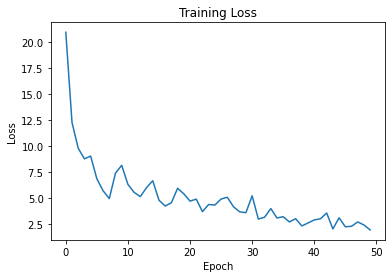

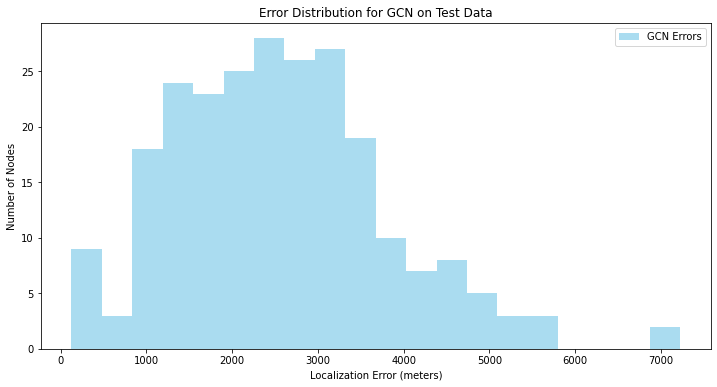

GCN Mean Error: 2558.2284 m, Median Error: 2470.4836 m


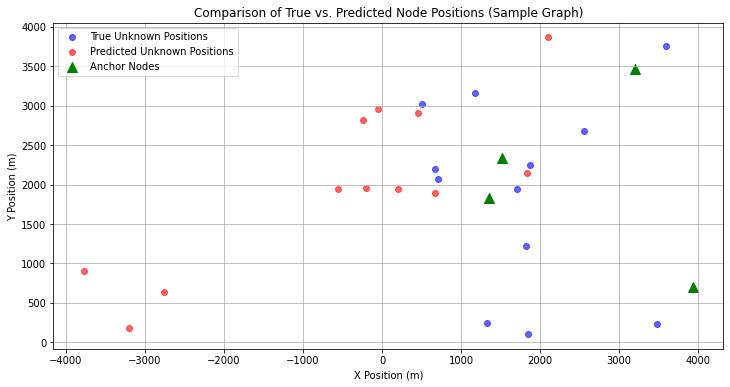

In [8]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, Parameter
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#######################################
# Parameters and Utility Functions
#######################################
num_instances = 100
num_anchors = 4
num_unknowns = 12
num_measurements = 10

# Origin from MATLAB code
mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (math.pi / 180) * earthRadius
metersPerDegreeLon = (math.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

#######################################
# Load Data
#######################################
data_list = []
for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"../matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    num_nodes = len(nodeLatitudes)
    node_x = np.zeros(num_nodes)
    node_y = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_x[i], node_y[i] = latlon_to_xy(nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon)

    # Construct edges
    edge_index_list = []
    edge_attr_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                # We will handle RSSI and delta_RSSI later. For now just store.
                edge_attr_list.append(signal_strength_matrix[i, j, :])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Identify anchors and unknowns
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:num_anchors] = True
    unknown_mask = ~anchor_mask

    # Initialize unknowns near average anchor position
    avg_anchor_x = node_x[anchor_mask].mean()
    avg_anchor_y = node_y[anchor_mask].mean()

    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < num_anchors else 0
        if is_anchor:
            node_features.append([node_x[i], node_y[i], is_anchor])
        else:
            node_features.append([avg_anchor_x + np.random.randn()*10,
                                  avg_anchor_y + np.random.randn()*10,
                                  is_anchor])

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    # Store original positions (not scaled) for distance calculation
    data.orig_positions = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data_list.append(data)

#######################################
# Scale Features and Targets
#######################################
all_features = torch.cat([d.x for d in data_list], dim=0).numpy()
feature_scaler = StandardScaler()
feature_scaler.fit(all_features)
for d in data_list:
    d.x = torch.tensor(feature_scaler.transform(d.x.numpy()), dtype=torch.float)

all_y = torch.cat([d.y for d in data_list], dim=0).numpy()
y_scaler = StandardScaler()
y_scaler.fit(all_y)
for d in data_list:
    d.y = torch.tensor(y_scaler.transform(d.y.numpy()), dtype=torch.float)

# Assume data_list contains 1000 instances
total_instances = len(data_list)
train_size = int(0.8 * total_instances)
test_size = total_instances - train_size

# Randomly split the data_list into training and testing sets
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# train_loader = DataLoader(data_list, batch_size=1, shuffle=True)
# test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

#######################################
# Physically Inspired Parameters
#######################################
# Learnable parameters for the RSSI model
Pt = Parameter(torch.tensor(0.0, requires_grad=True, device=device))
path_loss_exponent = Parameter(torch.tensor(3.0, requires_grad=True, device=device))
offset = Parameter(torch.tensor(-50.0, requires_grad=True, device=device))

#######################################
# Model Definition
#######################################
class MainEdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MainEdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 64),
            ReLU(),
            Linear(64, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class MainGNN(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, output_dim):
        super(MainGNN, self).__init__()
        self.edge_nn1 = MainEdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = MainEdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.fc(x)
        return x

node_in_dim = data_list[0].x.shape[1]
# We will add delta_RSSI as one additional feature to the existing edge attributes.
# Currently, edge_attr: shape = (num_edges, num_measurements)
# After adding delta_RSSI: shape = (num_edges, num_measurements + 1)
edge_in_dim = num_measurements + 1
hidden_dim = 64
output_dim = 2

main_gnn = MainGNN(node_in_dim=node_in_dim,
                   edge_in_dim=edge_in_dim,
                   hidden_dim=hidden_dim,
                   output_dim=output_dim).to(device)

params = list(main_gnn.parameters()) + [Pt, path_loss_exponent, offset]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-5)  # Lower LR for stability

#######################################
# Training
#######################################
num_epochs = 50
loss_history = []

def compute_distances(orig_positions, edge_index):
    # orig_positions: [num_nodes, 2]
    # edge_index: [2, num_edges]
    # return distances [num_edges, 1]
    src = edge_index[0]
    dst = edge_index[1]
    pos_src = orig_positions[src]
    pos_dst = orig_positions[dst]
    dist = torch.sqrt(torch.sum((pos_src - pos_dst)**2, dim=1))
    return dist

for epoch in range(num_epochs):
    main_gnn.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Compute distances in original space (not scaled)
        dist = compute_distances(data.orig_positions, data.edge_index)

        # Compute expected RSSI
        # RSSI_expected = Pt - 10 * path_loss_exponent * log10(dist) + offset
        # Avoid log10(0), add a small epsilon
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset

        # measured_RSSI: take mean over the 10 measurements for simplicity
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)

        # New edge_attr: original + delta_RSSI
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        # Use Smooth L1 Loss for robustness
        loss = F.smooth_l1_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(main_gnn.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_([Pt, path_loss_exponent, offset], 1.0)

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#######################################
# Evaluation
#######################################
main_gnn.eval()
errors_gcn = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        dist = compute_distances(data.orig_positions, data.edge_index)
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        predicted_scaled = out.cpu().numpy()
        predicted_positions = y_scaler.inverse_transform(predicted_scaled)
        true_positions = y_scaler.inverse_transform(data.y.cpu().numpy())

        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
                errors_gcn.append(error)

errors_gcn = np.array(errors_gcn)
plt.figure(figsize=(12, 6))
plt.hist(errors_gcn, bins=20, alpha=0.7, color='skyblue', label='GCN Errors')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

mean_error = errors_gcn.mean()
median_error = np.median(errors_gcn)
print(f"GCN Mean Error: {mean_error:.4f} m, Median Error: {median_error:.4f} m")

# Visualization of one sample
sample_data = data_list[0].to(device)
with torch.no_grad():
    dist = compute_distances(sample_data.orig_positions, sample_data.edge_index)
    epsilon = 1e-6
    RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
    measured_RSSI = sample_data.edge_attr.mean(dim=1)
    delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
    new_edge_attr = torch.cat([sample_data.edge_attr, delta_RSSI], dim=1)

    out = main_gnn(sample_data.x, sample_data.edge_index, new_edge_attr)
    predicted_scaled = out.cpu().numpy()
    predicted_positions = y_scaler.inverse_transform(predicted_scaled)
    true_positions = y_scaler.inverse_transform(sample_data.y.cpu().numpy())

predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

plt.figure(figsize=(12,6))
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0],
            true_positions[sample_data.unknown_mask.cpu(),1],
            c='blue', label='True Unknown Positions', alpha=0.6)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0],
            predicted_positions[sample_data.unknown_mask.cpu(),1],
            c='red', label='Predicted Unknown Positions', alpha=0.6)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0],
            true_positions[sample_data.anchor_mask.cpu(),1],
            c='green', marker='^', s=100, label='Anchor Nodes')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of True vs. Predicted Node Positions (Sample Graph)')
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


Loading MATLAB data: 100%|██████████| 200/200 [00:00<00:00, 274.55it/s]
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 15.8504
Epoch 2, Loss: 5.3830
Epoch 3, Loss: 3.6759
Epoch 4, Loss: 3.9966
Epoch 5, Loss: 3.7071
Epoch 6, Loss: 3.2606
Epoch 7, Loss: 3.3315
Epoch 8, Loss: 3.2531
Epoch 9, Loss: 2.6452
Epoch 10, Loss: 2.8668
Epoch 11, Loss: 2.4875
Epoch 12, Loss: 2.4391
Epoch 13, Loss: 1.9484
Epoch 14, Loss: 2.3971
Epoch 15, Loss: 2.0020
Epoch 16, Loss: 1.5590
Epoch 17, Loss: 1.9304
Epoch 18, Loss: 1.8057
Epoch 19, Loss: 2.0396
Epoch 20, Loss: 1.6199
Epoch 21, Loss: 1.3871
Epoch 22, Loss: 1.3555
Epoch 23, Loss: 1.5081
Epoch 24, Loss: 1.4187
Epoch 25, Loss: 1.5870
Epoch 26, Loss: 1.8069
Epoch 27, Loss: 1.3826
Epoch 28, Loss: 1.4259
Epoch 29, Loss: 1.2702
Epoch 30, Loss: 1.2117
Epoch 31, Loss: 1.0133
Epoch 32, Loss: 1.2701
Epoch 33, Loss: 1.1809
Epoch 34, Loss: 1.1525
Epoch 35, Loss: 0.8733
Epoch 36, Loss: 0.8327
Epoch 37, Loss: 1.1688
Epoch 38, Loss: 0.8783
Epoch 39, Loss: 1.1283
Epoch 40, Loss: 0.8857
Epoch 41, Loss: 0.9948
Epoch 42, Loss: 1.0517
Epoch 43, Loss: 0.7703
Epoch 44, Loss: 0.7

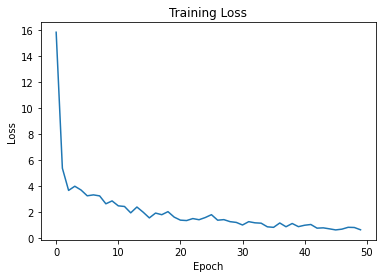

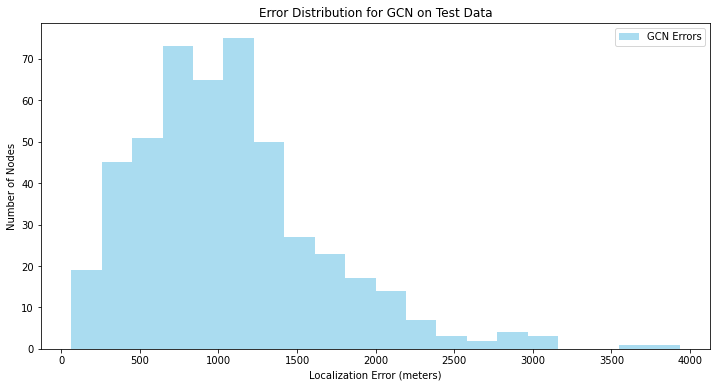

GCN Mean Error: 1066.1637 m, Median Error: 998.2975 m


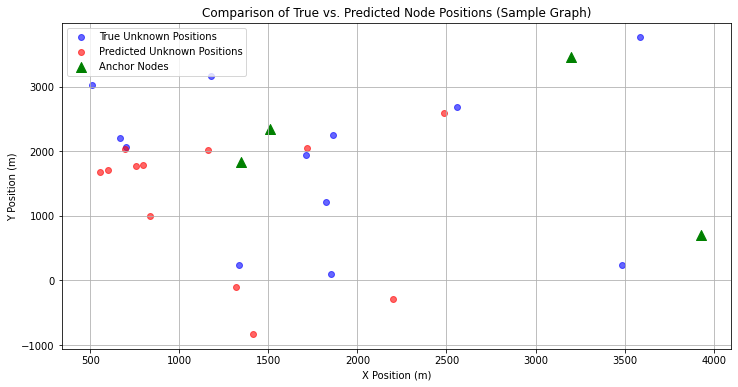

In [9]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, Parameter
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#######################################
# Parameters and Utility Functions
#######################################
num_instances = 200
num_anchors = 4
num_unknowns = 12
num_measurements = 10

# Origin from MATLAB code
mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (math.pi / 180) * earthRadius
metersPerDegreeLon = (math.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

#######################################
# Load Data
#######################################
data_list = []
for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"../matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    num_nodes = len(nodeLatitudes)
    node_x = np.zeros(num_nodes)
    node_y = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_x[i], node_y[i] = latlon_to_xy(nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon)

    # Construct edges
    edge_index_list = []
    edge_attr_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                # We will handle RSSI and delta_RSSI later. For now just store.
                edge_attr_list.append(signal_strength_matrix[i, j, :])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Identify anchors and unknowns
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:num_anchors] = True
    unknown_mask = ~anchor_mask

    # Initialize unknowns near average anchor position
    avg_anchor_x = node_x[anchor_mask].mean()
    avg_anchor_y = node_y[anchor_mask].mean()

    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < num_anchors else 0
        if is_anchor:
            node_features.append([node_x[i], node_y[i], is_anchor])
        else:
            node_features.append([avg_anchor_x + np.random.randn()*10,
                                  avg_anchor_y + np.random.randn()*10,
                                  is_anchor])

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    # Store original positions (not scaled) for distance calculation
    data.orig_positions = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data_list.append(data)

#######################################
# Scale Features and Targets
#######################################
all_features = torch.cat([d.x for d in data_list], dim=0).numpy()
feature_scaler = StandardScaler()
feature_scaler.fit(all_features)
for d in data_list:
    d.x = torch.tensor(feature_scaler.transform(d.x.numpy()), dtype=torch.float)

all_y = torch.cat([d.y for d in data_list], dim=0).numpy()
y_scaler = StandardScaler()
y_scaler.fit(all_y)
for d in data_list:
    d.y = torch.tensor(y_scaler.transform(d.y.numpy()), dtype=torch.float)

# Assume data_list contains 1000 instances
total_instances = len(data_list)
train_size = int(0.8 * total_instances)
test_size = total_instances - train_size

# Randomly split the data_list into training and testing sets
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# train_loader = DataLoader(data_list, batch_size=1, shuffle=True)
# test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

#######################################
# Physically Inspired Parameters
#######################################
# Learnable parameters for the RSSI model
Pt = Parameter(torch.tensor(0.0, requires_grad=True, device=device))
path_loss_exponent = Parameter(torch.tensor(3.0, requires_grad=True, device=device))
offset = Parameter(torch.tensor(-50.0, requires_grad=True, device=device))

#######################################
# Model Definition
#######################################
class MainEdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MainEdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 64),
            ReLU(),
            Linear(64, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class MainGNN(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, output_dim):
        super(MainGNN, self).__init__()
        self.edge_nn1 = MainEdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = MainEdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.fc(x)
        return x

node_in_dim = data_list[0].x.shape[1]
# We will add delta_RSSI as one additional feature to the existing edge attributes.
# Currently, edge_attr: shape = (num_edges, num_measurements)
# After adding delta_RSSI: shape = (num_edges, num_measurements + 1)
edge_in_dim = num_measurements + 1
hidden_dim = 64
output_dim = 2

main_gnn = MainGNN(node_in_dim=node_in_dim,
                   edge_in_dim=edge_in_dim,
                   hidden_dim=hidden_dim,
                   output_dim=output_dim).to(device)

params = list(main_gnn.parameters()) + [Pt, path_loss_exponent, offset]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-5)  # Lower LR for stability

#######################################
# Training
#######################################
num_epochs = 50
loss_history = []

def compute_distances(orig_positions, edge_index):
    # orig_positions: [num_nodes, 2]
    # edge_index: [2, num_edges]
    # return distances [num_edges, 1]
    src = edge_index[0]
    dst = edge_index[1]
    pos_src = orig_positions[src]
    pos_dst = orig_positions[dst]
    dist = torch.sqrt(torch.sum((pos_src - pos_dst)**2, dim=1))
    return dist

for epoch in range(num_epochs):
    main_gnn.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Compute distances in original space (not scaled)
        dist = compute_distances(data.orig_positions, data.edge_index)

        # Compute expected RSSI
        # RSSI_expected = Pt - 10 * path_loss_exponent * log10(dist) + offset
        # Avoid log10(0), add a small epsilon
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset

        # measured_RSSI: take mean over the 10 measurements for simplicity
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)

        # New edge_attr: original + delta_RSSI
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        # Use Smooth L1 Loss for robustness
        loss = F.smooth_l1_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(main_gnn.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_([Pt, path_loss_exponent, offset], 1.0)

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#######################################
# Evaluation
#######################################
main_gnn.eval()
errors_gcn = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        dist = compute_distances(data.orig_positions, data.edge_index)
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        predicted_scaled = out.cpu().numpy()
        predicted_positions = y_scaler.inverse_transform(predicted_scaled)
        true_positions = y_scaler.inverse_transform(data.y.cpu().numpy())

        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
                errors_gcn.append(error)

errors_gcn = np.array(errors_gcn)
plt.figure(figsize=(12, 6))
plt.hist(errors_gcn, bins=20, alpha=0.7, color='skyblue', label='GCN Errors')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

mean_error = errors_gcn.mean()
median_error = np.median(errors_gcn)
print(f"GCN Mean Error: {mean_error:.4f} m, Median Error: {median_error:.4f} m")

# Visualization of one sample
sample_data = data_list[0].to(device)
with torch.no_grad():
    dist = compute_distances(sample_data.orig_positions, sample_data.edge_index)
    epsilon = 1e-6
    RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
    measured_RSSI = sample_data.edge_attr.mean(dim=1)
    delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
    new_edge_attr = torch.cat([sample_data.edge_attr, delta_RSSI], dim=1)

    out = main_gnn(sample_data.x, sample_data.edge_index, new_edge_attr)
    predicted_scaled = out.cpu().numpy()
    predicted_positions = y_scaler.inverse_transform(predicted_scaled)
    true_positions = y_scaler.inverse_transform(sample_data.y.cpu().numpy())

predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

plt.figure(figsize=(12,6))
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0],
            true_positions[sample_data.unknown_mask.cpu(),1],
            c='blue', label='True Unknown Positions', alpha=0.6)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0],
            predicted_positions[sample_data.unknown_mask.cpu(),1],
            c='red', label='Predicted Unknown Positions', alpha=0.6)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0],
            true_positions[sample_data.anchor_mask.cpu(),1],
            c='green', marker='^', s=100, label='Anchor Nodes')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of True vs. Predicted Node Positions (Sample Graph)')
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


Loading MATLAB data: 100%|██████████| 300/300 [00:00<00:00, 381.61it/s]
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 11.4943
Epoch 2, Loss: 4.3980
Epoch 3, Loss: 3.8125
Epoch 4, Loss: 3.6176
Epoch 5, Loss: 3.8219
Epoch 6, Loss: 2.5644
Epoch 7, Loss: 3.6388
Epoch 8, Loss: 3.1739
Epoch 9, Loss: 2.6689
Epoch 10, Loss: 2.8592
Epoch 11, Loss: 2.3443
Epoch 12, Loss: 2.0219
Epoch 13, Loss: 2.2879
Epoch 14, Loss: 2.3413
Epoch 15, Loss: 2.2640
Epoch 16, Loss: 2.0631
Epoch 17, Loss: 1.5576
Epoch 18, Loss: 1.8080
Epoch 19, Loss: 1.9576
Epoch 20, Loss: 1.8880
Epoch 21, Loss: 1.5987
Epoch 22, Loss: 1.5026
Epoch 23, Loss: 1.6539
Epoch 24, Loss: 1.2705
Epoch 25, Loss: 1.1883
Epoch 26, Loss: 1.0020
Epoch 27, Loss: 1.0752
Epoch 28, Loss: 0.9864
Epoch 29, Loss: 1.0456
Epoch 30, Loss: 1.0467
Epoch 31, Loss: 0.7799
Epoch 32, Loss: 0.8508
Epoch 33, Loss: 0.7785
Epoch 34, Loss: 0.8758
Epoch 35, Loss: 0.7711
Epoch 36, Loss: 0.6477
Epoch 37, Loss: 0.6623
Epoch 38, Loss: 0.6807
Epoch 39, Loss: 0.5594
Epoch 40, Loss: 0.5320
Epoch 41, Loss: 0.7176
Epoch 42, Loss: 0.5259
Epoch 43, Loss: 0.5402
Epoch 44, Loss: 0.5

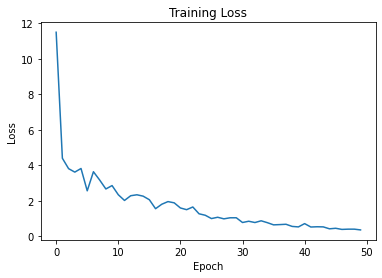

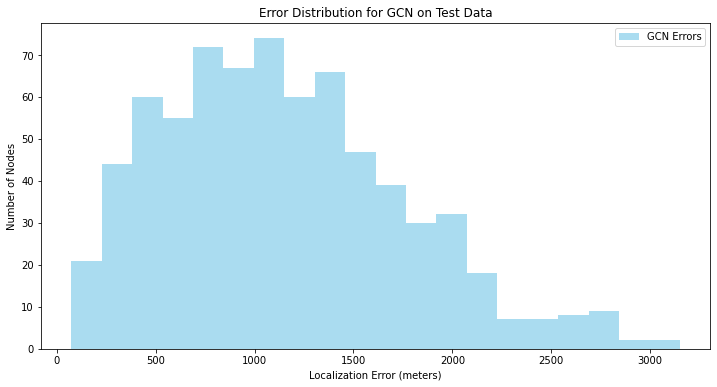

GCN Mean Error: 1148.5994 m, Median Error: 1078.1406 m


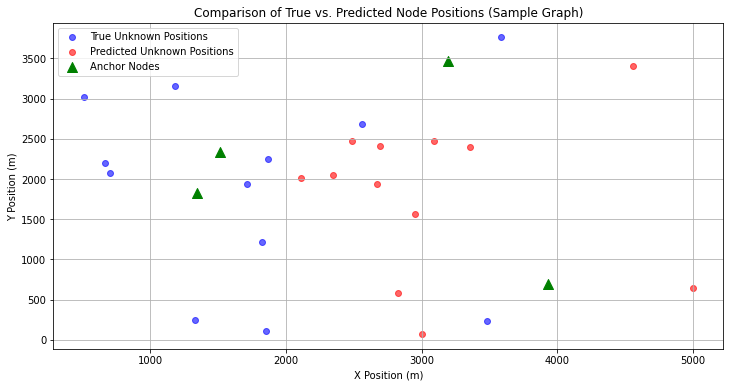

In [10]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, Parameter
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#######################################
# Parameters and Utility Functions
#######################################
num_instances = 300
num_anchors = 4
num_unknowns = 12
num_measurements = 10

# Origin from MATLAB code
mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (math.pi / 180) * earthRadius
metersPerDegreeLon = (math.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

#######################################
# Load Data
#######################################
data_list = []
for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"../matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    num_nodes = len(nodeLatitudes)
    node_x = np.zeros(num_nodes)
    node_y = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_x[i], node_y[i] = latlon_to_xy(nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon)

    # Construct edges
    edge_index_list = []
    edge_attr_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                # We will handle RSSI and delta_RSSI later. For now just store.
                edge_attr_list.append(signal_strength_matrix[i, j, :])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Identify anchors and unknowns
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:num_anchors] = True
    unknown_mask = ~anchor_mask

    # Initialize unknowns near average anchor position
    avg_anchor_x = node_x[anchor_mask].mean()
    avg_anchor_y = node_y[anchor_mask].mean()

    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < num_anchors else 0
        if is_anchor:
            node_features.append([node_x[i], node_y[i], is_anchor])
        else:
            node_features.append([avg_anchor_x + np.random.randn()*10,
                                  avg_anchor_y + np.random.randn()*10,
                                  is_anchor])

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    # Store original positions (not scaled) for distance calculation
    data.orig_positions = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data_list.append(data)

#######################################
# Scale Features and Targets
#######################################
all_features = torch.cat([d.x for d in data_list], dim=0).numpy()
feature_scaler = StandardScaler()
feature_scaler.fit(all_features)
for d in data_list:
    d.x = torch.tensor(feature_scaler.transform(d.x.numpy()), dtype=torch.float)

all_y = torch.cat([d.y for d in data_list], dim=0).numpy()
y_scaler = StandardScaler()
y_scaler.fit(all_y)
for d in data_list:
    d.y = torch.tensor(y_scaler.transform(d.y.numpy()), dtype=torch.float)

# Assume data_list contains 1000 instances
total_instances = len(data_list)
train_size = int(0.8 * total_instances)
test_size = total_instances - train_size

# Randomly split the data_list into training and testing sets
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# train_loader = DataLoader(data_list, batch_size=1, shuffle=True)
# test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

#######################################
# Physically Inspired Parameters
#######################################
# Learnable parameters for the RSSI model
Pt = Parameter(torch.tensor(0.0, requires_grad=True, device=device))
path_loss_exponent = Parameter(torch.tensor(3.0, requires_grad=True, device=device))
offset = Parameter(torch.tensor(-50.0, requires_grad=True, device=device))

#######################################
# Model Definition
#######################################
class MainEdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MainEdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 64),
            ReLU(),
            Linear(64, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class MainGNN(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, output_dim):
        super(MainGNN, self).__init__()
        self.edge_nn1 = MainEdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = MainEdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.fc(x)
        return x

node_in_dim = data_list[0].x.shape[1]
# We will add delta_RSSI as one additional feature to the existing edge attributes.
# Currently, edge_attr: shape = (num_edges, num_measurements)
# After adding delta_RSSI: shape = (num_edges, num_measurements + 1)
edge_in_dim = num_measurements + 1
hidden_dim = 64
output_dim = 2

main_gnn = MainGNN(node_in_dim=node_in_dim,
                   edge_in_dim=edge_in_dim,
                   hidden_dim=hidden_dim,
                   output_dim=output_dim).to(device)

params = list(main_gnn.parameters()) + [Pt, path_loss_exponent, offset]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-5)  # Lower LR for stability

#######################################
# Training
#######################################
num_epochs = 50
loss_history = []

def compute_distances(orig_positions, edge_index):
    # orig_positions: [num_nodes, 2]
    # edge_index: [2, num_edges]
    # return distances [num_edges, 1]
    src = edge_index[0]
    dst = edge_index[1]
    pos_src = orig_positions[src]
    pos_dst = orig_positions[dst]
    dist = torch.sqrt(torch.sum((pos_src - pos_dst)**2, dim=1))
    return dist

for epoch in range(num_epochs):
    main_gnn.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Compute distances in original space (not scaled)
        dist = compute_distances(data.orig_positions, data.edge_index)

        # Compute expected RSSI
        # RSSI_expected = Pt - 10 * path_loss_exponent * log10(dist) + offset
        # Avoid log10(0), add a small epsilon
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset

        # measured_RSSI: take mean over the 10 measurements for simplicity
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)

        # New edge_attr: original + delta_RSSI
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        # Use Smooth L1 Loss for robustness
        loss = F.smooth_l1_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(main_gnn.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_([Pt, path_loss_exponent, offset], 1.0)

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#######################################
# Evaluation
#######################################
main_gnn.eval()
errors_gcn = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        dist = compute_distances(data.orig_positions, data.edge_index)
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        predicted_scaled = out.cpu().numpy()
        predicted_positions = y_scaler.inverse_transform(predicted_scaled)
        true_positions = y_scaler.inverse_transform(data.y.cpu().numpy())

        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
                errors_gcn.append(error)

errors_gcn = np.array(errors_gcn)
plt.figure(figsize=(12, 6))
plt.hist(errors_gcn, bins=20, alpha=0.7, color='skyblue', label='GCN Errors')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

mean_error = errors_gcn.mean()
median_error = np.median(errors_gcn)
print(f"GCN Mean Error: {mean_error:.4f} m, Median Error: {median_error:.4f} m")

# Visualization of one sample
sample_data = data_list[0].to(device)
with torch.no_grad():
    dist = compute_distances(sample_data.orig_positions, sample_data.edge_index)
    epsilon = 1e-6
    RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
    measured_RSSI = sample_data.edge_attr.mean(dim=1)
    delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
    new_edge_attr = torch.cat([sample_data.edge_attr, delta_RSSI], dim=1)

    out = main_gnn(sample_data.x, sample_data.edge_index, new_edge_attr)
    predicted_scaled = out.cpu().numpy()
    predicted_positions = y_scaler.inverse_transform(predicted_scaled)
    true_positions = y_scaler.inverse_transform(sample_data.y.cpu().numpy())

predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

plt.figure(figsize=(12,6))
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0],
            true_positions[sample_data.unknown_mask.cpu(),1],
            c='blue', label='True Unknown Positions', alpha=0.6)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0],
            predicted_positions[sample_data.unknown_mask.cpu(),1],
            c='red', label='Predicted Unknown Positions', alpha=0.6)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0],
            true_positions[sample_data.anchor_mask.cpu(),1],
            c='green', marker='^', s=100, label='Anchor Nodes')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of True vs. Predicted Node Positions (Sample Graph)')
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


Loading MATLAB data: 100%|██████████| 400/400 [00:00<00:00, 474.45it/s] 
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 16.9832
Epoch 2, Loss: 7.0683
Epoch 3, Loss: 5.6563
Epoch 4, Loss: 3.8415
Epoch 5, Loss: 4.1637
Epoch 6, Loss: 3.5613
Epoch 7, Loss: 3.9688
Epoch 8, Loss: 3.0321
Epoch 9, Loss: 2.6949
Epoch 10, Loss: 2.6482
Epoch 11, Loss: 2.2006
Epoch 12, Loss: 2.1639
Epoch 13, Loss: 2.2136
Epoch 14, Loss: 2.2700
Epoch 15, Loss: 2.1604
Epoch 16, Loss: 1.7047
Epoch 17, Loss: 1.7483
Epoch 18, Loss: 1.4469
Epoch 19, Loss: 1.4985
Epoch 20, Loss: 1.5686
Epoch 21, Loss: 1.1226
Epoch 22, Loss: 1.3037
Epoch 23, Loss: 1.0093
Epoch 24, Loss: 1.0948
Epoch 25, Loss: 0.9897
Epoch 26, Loss: 0.9288
Epoch 27, Loss: 0.9454
Epoch 28, Loss: 0.8361
Epoch 29, Loss: 0.7642
Epoch 30, Loss: 0.7713
Epoch 31, Loss: 0.6600
Epoch 32, Loss: 0.6757
Epoch 33, Loss: 0.6104
Epoch 34, Loss: 0.5946
Epoch 35, Loss: 0.5736
Epoch 36, Loss: 0.5177
Epoch 37, Loss: 0.4160
Epoch 38, Loss: 0.4599
Epoch 39, Loss: 0.4245
Epoch 40, Loss: 0.4895
Epoch 41, Loss: 0.4559
Epoch 42, Loss: 0.4467
Epoch 43, Loss: 0.3801
Epoch 44, Loss: 0.3

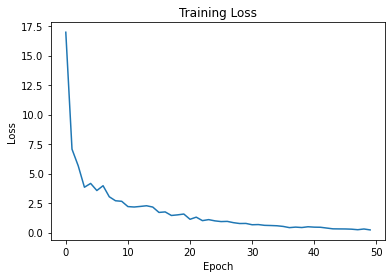

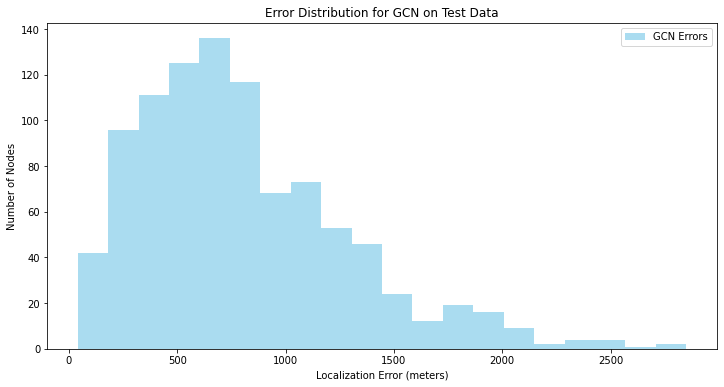

GCN Mean Error: 803.0847 m, Median Error: 705.9906 m


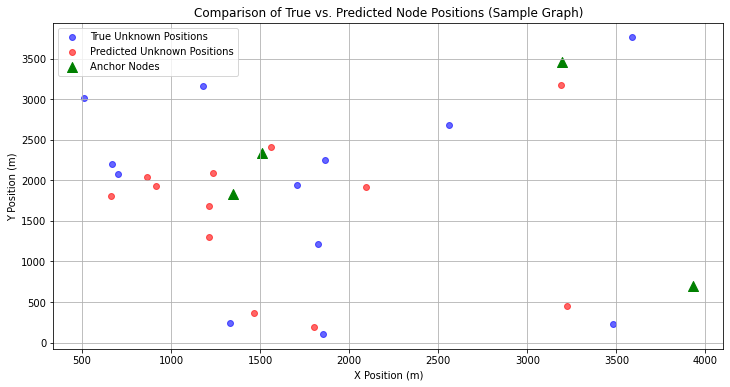

In [11]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, Parameter
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#######################################
# Parameters and Utility Functions
#######################################
num_instances = 400
num_anchors = 4
num_unknowns = 12
num_measurements = 10

# Origin from MATLAB code
mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (math.pi / 180) * earthRadius
metersPerDegreeLon = (math.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

#######################################
# Load Data
#######################################
data_list = []
for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"../matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    num_nodes = len(nodeLatitudes)
    node_x = np.zeros(num_nodes)
    node_y = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_x[i], node_y[i] = latlon_to_xy(nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon)

    # Construct edges
    edge_index_list = []
    edge_attr_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                # We will handle RSSI and delta_RSSI later. For now just store.
                edge_attr_list.append(signal_strength_matrix[i, j, :])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Identify anchors and unknowns
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:num_anchors] = True
    unknown_mask = ~anchor_mask

    # Initialize unknowns near average anchor position
    avg_anchor_x = node_x[anchor_mask].mean()
    avg_anchor_y = node_y[anchor_mask].mean()

    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < num_anchors else 0
        if is_anchor:
            node_features.append([node_x[i], node_y[i], is_anchor])
        else:
            node_features.append([avg_anchor_x + np.random.randn()*10,
                                  avg_anchor_y + np.random.randn()*10,
                                  is_anchor])

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    # Store original positions (not scaled) for distance calculation
    data.orig_positions = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data_list.append(data)

#######################################
# Scale Features and Targets
#######################################
all_features = torch.cat([d.x for d in data_list], dim=0).numpy()
feature_scaler = StandardScaler()
feature_scaler.fit(all_features)
for d in data_list:
    d.x = torch.tensor(feature_scaler.transform(d.x.numpy()), dtype=torch.float)

all_y = torch.cat([d.y for d in data_list], dim=0).numpy()
y_scaler = StandardScaler()
y_scaler.fit(all_y)
for d in data_list:
    d.y = torch.tensor(y_scaler.transform(d.y.numpy()), dtype=torch.float)

# Assume data_list contains 1000 instances
total_instances = len(data_list)
train_size = int(0.8 * total_instances)
test_size = total_instances - train_size

# Randomly split the data_list into training and testing sets
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# train_loader = DataLoader(data_list, batch_size=1, shuffle=True)
# test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

#######################################
# Physically Inspired Parameters
#######################################
# Learnable parameters for the RSSI model
Pt = Parameter(torch.tensor(0.0, requires_grad=True, device=device))
path_loss_exponent = Parameter(torch.tensor(3.0, requires_grad=True, device=device))
offset = Parameter(torch.tensor(-50.0, requires_grad=True, device=device))

#######################################
# Model Definition
#######################################
class MainEdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MainEdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 64),
            ReLU(),
            Linear(64, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class MainGNN(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, output_dim):
        super(MainGNN, self).__init__()
        self.edge_nn1 = MainEdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = MainEdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.fc(x)
        return x

node_in_dim = data_list[0].x.shape[1]
# We will add delta_RSSI as one additional feature to the existing edge attributes.
# Currently, edge_attr: shape = (num_edges, num_measurements)
# After adding delta_RSSI: shape = (num_edges, num_measurements + 1)
edge_in_dim = num_measurements + 1
hidden_dim = 64
output_dim = 2

main_gnn = MainGNN(node_in_dim=node_in_dim,
                   edge_in_dim=edge_in_dim,
                   hidden_dim=hidden_dim,
                   output_dim=output_dim).to(device)

params = list(main_gnn.parameters()) + [Pt, path_loss_exponent, offset]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-5)  # Lower LR for stability

#######################################
# Training
#######################################
num_epochs = 50
loss_history = []

def compute_distances(orig_positions, edge_index):
    # orig_positions: [num_nodes, 2]
    # edge_index: [2, num_edges]
    # return distances [num_edges, 1]
    src = edge_index[0]
    dst = edge_index[1]
    pos_src = orig_positions[src]
    pos_dst = orig_positions[dst]
    dist = torch.sqrt(torch.sum((pos_src - pos_dst)**2, dim=1))
    return dist

for epoch in range(num_epochs):
    main_gnn.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Compute distances in original space (not scaled)
        dist = compute_distances(data.orig_positions, data.edge_index)

        # Compute expected RSSI
        # RSSI_expected = Pt - 10 * path_loss_exponent * log10(dist) + offset
        # Avoid log10(0), add a small epsilon
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset

        # measured_RSSI: take mean over the 10 measurements for simplicity
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)

        # New edge_attr: original + delta_RSSI
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        # Use Smooth L1 Loss for robustness
        loss = F.smooth_l1_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(main_gnn.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_([Pt, path_loss_exponent, offset], 1.0)

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#######################################
# Evaluation
#######################################
main_gnn.eval()
errors_gcn = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        dist = compute_distances(data.orig_positions, data.edge_index)
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        predicted_scaled = out.cpu().numpy()
        predicted_positions = y_scaler.inverse_transform(predicted_scaled)
        true_positions = y_scaler.inverse_transform(data.y.cpu().numpy())

        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
                errors_gcn.append(error)

errors_gcn = np.array(errors_gcn)
plt.figure(figsize=(12, 6))
plt.hist(errors_gcn, bins=20, alpha=0.7, color='skyblue', label='GCN Errors')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

mean_error = errors_gcn.mean()
median_error = np.median(errors_gcn)
print(f"GCN Mean Error: {mean_error:.4f} m, Median Error: {median_error:.4f} m")

# Visualization of one sample
sample_data = data_list[0].to(device)
with torch.no_grad():
    dist = compute_distances(sample_data.orig_positions, sample_data.edge_index)
    epsilon = 1e-6
    RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
    measured_RSSI = sample_data.edge_attr.mean(dim=1)
    delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
    new_edge_attr = torch.cat([sample_data.edge_attr, delta_RSSI], dim=1)

    out = main_gnn(sample_data.x, sample_data.edge_index, new_edge_attr)
    predicted_scaled = out.cpu().numpy()
    predicted_positions = y_scaler.inverse_transform(predicted_scaled)
    true_positions = y_scaler.inverse_transform(sample_data.y.cpu().numpy())

predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

plt.figure(figsize=(12,6))
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0],
            true_positions[sample_data.unknown_mask.cpu(),1],
            c='blue', label='True Unknown Positions', alpha=0.6)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0],
            predicted_positions[sample_data.unknown_mask.cpu(),1],
            c='red', label='Predicted Unknown Positions', alpha=0.6)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0],
            true_positions[sample_data.anchor_mask.cpu(),1],
            c='green', marker='^', s=100, label='Anchor Nodes')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of True vs. Predicted Node Positions (Sample Graph)')
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


Loading MATLAB data: 100%|██████████| 500/500 [00:00<00:00, 548.44it/s] 
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 11.4173
Epoch 2, Loss: 7.3145
Epoch 3, Loss: 5.2244
Epoch 4, Loss: 4.5015
Epoch 5, Loss: 4.0277
Epoch 6, Loss: 3.7579
Epoch 7, Loss: 3.8177
Epoch 8, Loss: 3.3076
Epoch 9, Loss: 2.7957
Epoch 10, Loss: 2.7819
Epoch 11, Loss: 2.6197
Epoch 12, Loss: 2.3721
Epoch 13, Loss: 2.2129
Epoch 14, Loss: 2.0998
Epoch 15, Loss: 1.4254
Epoch 16, Loss: 1.5444
Epoch 17, Loss: 1.3770
Epoch 18, Loss: 1.8330
Epoch 19, Loss: 1.3581
Epoch 20, Loss: 1.0633
Epoch 21, Loss: 1.2883
Epoch 22, Loss: 0.9573
Epoch 23, Loss: 0.9372
Epoch 24, Loss: 0.7060
Epoch 25, Loss: 0.6345
Epoch 26, Loss: 0.8346
Epoch 27, Loss: 0.5450
Epoch 28, Loss: 0.4536
Epoch 29, Loss: 0.5516
Epoch 30, Loss: 0.4528
Epoch 31, Loss: 0.4521
Epoch 32, Loss: 0.4153
Epoch 33, Loss: 0.3329
Epoch 34, Loss: 0.3854
Epoch 35, Loss: 0.3476
Epoch 36, Loss: 0.2842
Epoch 37, Loss: 0.2707
Epoch 38, Loss: 0.2881
Epoch 39, Loss: 0.2408
Epoch 40, Loss: 0.2125
Epoch 41, Loss: 0.1951
Epoch 42, Loss: 0.2075
Epoch 43, Loss: 0.2010
Epoch 44, Loss: 0.1

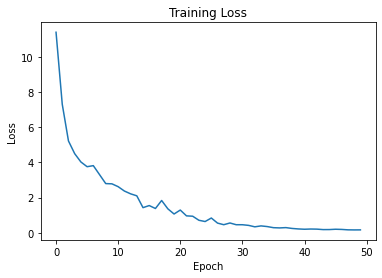

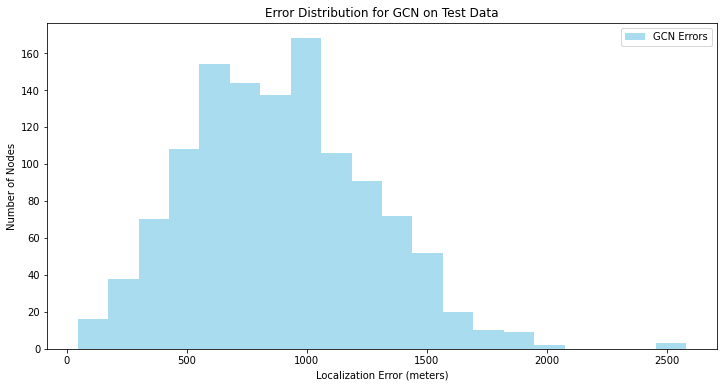

GCN Mean Error: 886.3534 m, Median Error: 863.2725 m


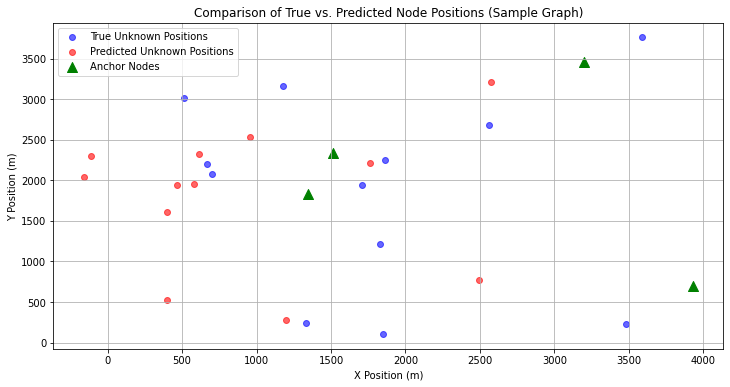

In [12]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, Parameter
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#######################################
# Parameters and Utility Functions
#######################################
num_instances = 500
num_anchors = 4
num_unknowns = 12
num_measurements = 10

# Origin from MATLAB code
mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (math.pi / 180) * earthRadius
metersPerDegreeLon = (math.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

#######################################
# Load Data
#######################################
data_list = []
for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"../matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    num_nodes = len(nodeLatitudes)
    node_x = np.zeros(num_nodes)
    node_y = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_x[i], node_y[i] = latlon_to_xy(nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon)

    # Construct edges
    edge_index_list = []
    edge_attr_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                # We will handle RSSI and delta_RSSI later. For now just store.
                edge_attr_list.append(signal_strength_matrix[i, j, :])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Identify anchors and unknowns
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:num_anchors] = True
    unknown_mask = ~anchor_mask

    # Initialize unknowns near average anchor position
    avg_anchor_x = node_x[anchor_mask].mean()
    avg_anchor_y = node_y[anchor_mask].mean()

    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < num_anchors else 0
        if is_anchor:
            node_features.append([node_x[i], node_y[i], is_anchor])
        else:
            node_features.append([avg_anchor_x + np.random.randn()*10,
                                  avg_anchor_y + np.random.randn()*10,
                                  is_anchor])

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    # Store original positions (not scaled) for distance calculation
    data.orig_positions = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data_list.append(data)

#######################################
# Scale Features and Targets
#######################################
all_features = torch.cat([d.x for d in data_list], dim=0).numpy()
feature_scaler = StandardScaler()
feature_scaler.fit(all_features)
for d in data_list:
    d.x = torch.tensor(feature_scaler.transform(d.x.numpy()), dtype=torch.float)

all_y = torch.cat([d.y for d in data_list], dim=0).numpy()
y_scaler = StandardScaler()
y_scaler.fit(all_y)
for d in data_list:
    d.y = torch.tensor(y_scaler.transform(d.y.numpy()), dtype=torch.float)

# Assume data_list contains 1000 instances
total_instances = len(data_list)
train_size = int(0.8 * total_instances)
test_size = total_instances - train_size

# Randomly split the data_list into training and testing sets
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# train_loader = DataLoader(data_list, batch_size=1, shuffle=True)
# test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

#######################################
# Physically Inspired Parameters
#######################################
# Learnable parameters for the RSSI model
Pt = Parameter(torch.tensor(0.0, requires_grad=True, device=device))
path_loss_exponent = Parameter(torch.tensor(3.0, requires_grad=True, device=device))
offset = Parameter(torch.tensor(-50.0, requires_grad=True, device=device))

#######################################
# Model Definition
#######################################
class MainEdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MainEdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 64),
            ReLU(),
            Linear(64, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class MainGNN(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, output_dim):
        super(MainGNN, self).__init__()
        self.edge_nn1 = MainEdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = MainEdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.fc(x)
        return x

node_in_dim = data_list[0].x.shape[1]
# We will add delta_RSSI as one additional feature to the existing edge attributes.
# Currently, edge_attr: shape = (num_edges, num_measurements)
# After adding delta_RSSI: shape = (num_edges, num_measurements + 1)
edge_in_dim = num_measurements + 1
hidden_dim = 64
output_dim = 2

main_gnn = MainGNN(node_in_dim=node_in_dim,
                   edge_in_dim=edge_in_dim,
                   hidden_dim=hidden_dim,
                   output_dim=output_dim).to(device)

params = list(main_gnn.parameters()) + [Pt, path_loss_exponent, offset]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-5)  # Lower LR for stability

#######################################
# Training
#######################################
num_epochs = 50
loss_history = []

def compute_distances(orig_positions, edge_index):
    # orig_positions: [num_nodes, 2]
    # edge_index: [2, num_edges]
    # return distances [num_edges, 1]
    src = edge_index[0]
    dst = edge_index[1]
    pos_src = orig_positions[src]
    pos_dst = orig_positions[dst]
    dist = torch.sqrt(torch.sum((pos_src - pos_dst)**2, dim=1))
    return dist

for epoch in range(num_epochs):
    main_gnn.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Compute distances in original space (not scaled)
        dist = compute_distances(data.orig_positions, data.edge_index)

        # Compute expected RSSI
        # RSSI_expected = Pt - 10 * path_loss_exponent * log10(dist) + offset
        # Avoid log10(0), add a small epsilon
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset

        # measured_RSSI: take mean over the 10 measurements for simplicity
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)

        # New edge_attr: original + delta_RSSI
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        # Use Smooth L1 Loss for robustness
        loss = F.smooth_l1_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(main_gnn.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_([Pt, path_loss_exponent, offset], 1.0)

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#######################################
# Evaluation
#######################################
main_gnn.eval()
errors_gcn = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        dist = compute_distances(data.orig_positions, data.edge_index)
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        predicted_scaled = out.cpu().numpy()
        predicted_positions = y_scaler.inverse_transform(predicted_scaled)
        true_positions = y_scaler.inverse_transform(data.y.cpu().numpy())

        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
                errors_gcn.append(error)

errors_gcn = np.array(errors_gcn)
plt.figure(figsize=(12, 6))
plt.hist(errors_gcn, bins=20, alpha=0.7, color='skyblue', label='GCN Errors')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

mean_error = errors_gcn.mean()
median_error = np.median(errors_gcn)
print(f"GCN Mean Error: {mean_error:.4f} m, Median Error: {median_error:.4f} m")

# Visualization of one sample
sample_data = data_list[0].to(device)
with torch.no_grad():
    dist = compute_distances(sample_data.orig_positions, sample_data.edge_index)
    epsilon = 1e-6
    RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
    measured_RSSI = sample_data.edge_attr.mean(dim=1)
    delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
    new_edge_attr = torch.cat([sample_data.edge_attr, delta_RSSI], dim=1)

    out = main_gnn(sample_data.x, sample_data.edge_index, new_edge_attr)
    predicted_scaled = out.cpu().numpy()
    predicted_positions = y_scaler.inverse_transform(predicted_scaled)
    true_positions = y_scaler.inverse_transform(sample_data.y.cpu().numpy())

predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

plt.figure(figsize=(12,6))
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0],
            true_positions[sample_data.unknown_mask.cpu(),1],
            c='blue', label='True Unknown Positions', alpha=0.6)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0],
            predicted_positions[sample_data.unknown_mask.cpu(),1],
            c='red', label='Predicted Unknown Positions', alpha=0.6)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0],
            true_positions[sample_data.anchor_mask.cpu(),1],
            c='green', marker='^', s=100, label='Anchor Nodes')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of True vs. Predicted Node Positions (Sample Graph)')
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


Loading MATLAB data: 100%|██████████| 600/600 [00:01<00:00, 586.69it/s]
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 7.3798
Epoch 2, Loss: 2.9107
Epoch 3, Loss: 2.5851
Epoch 4, Loss: 1.9495
Epoch 5, Loss: 1.8309
Epoch 6, Loss: 1.6484
Epoch 7, Loss: 1.5592
Epoch 8, Loss: 1.5690
Epoch 9, Loss: 1.1928
Epoch 10, Loss: 0.9355
Epoch 11, Loss: 0.9440
Epoch 12, Loss: 0.8013
Epoch 13, Loss: 0.7700
Epoch 14, Loss: 0.5781
Epoch 15, Loss: 0.6381
Epoch 16, Loss: 0.4689
Epoch 17, Loss: 0.4586
Epoch 18, Loss: 0.4161
Epoch 19, Loss: 0.3597
Epoch 20, Loss: 0.3940
Epoch 21, Loss: 0.3077
Epoch 22, Loss: 0.3273
Epoch 23, Loss: 0.2896
Epoch 24, Loss: 0.2589
Epoch 25, Loss: 0.2493
Epoch 26, Loss: 0.2311
Epoch 27, Loss: 0.2151
Epoch 28, Loss: 0.2094
Epoch 29, Loss: 0.1894
Epoch 30, Loss: 0.1876
Epoch 31, Loss: 0.1734
Epoch 32, Loss: 0.1358
Epoch 33, Loss: 0.1293
Epoch 34, Loss: 0.1312
Epoch 35, Loss: 0.1253
Epoch 36, Loss: 0.1163
Epoch 37, Loss: 0.1113
Epoch 38, Loss: 0.1017
Epoch 39, Loss: 0.0948
Epoch 40, Loss: 0.0956
Epoch 41, Loss: 0.0898
Epoch 42, Loss: 0.0877
Epoch 43, Loss: 0.0787
Epoch 44, Loss: 0.07

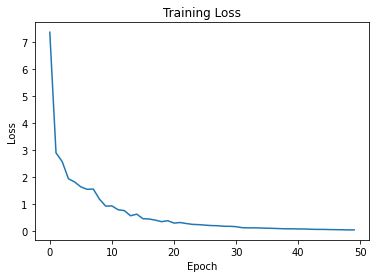

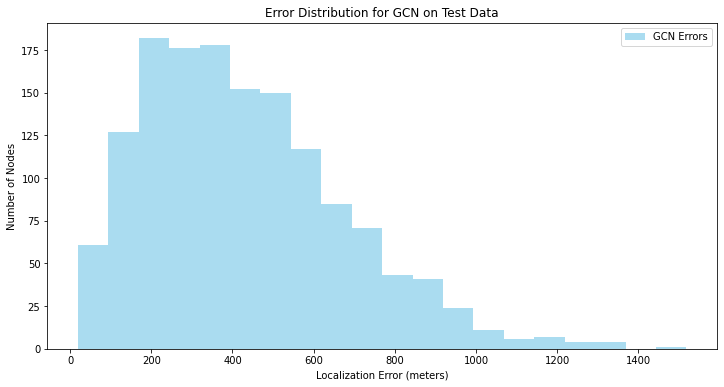

GCN Mean Error: 430.1662 m, Median Error: 392.0216 m


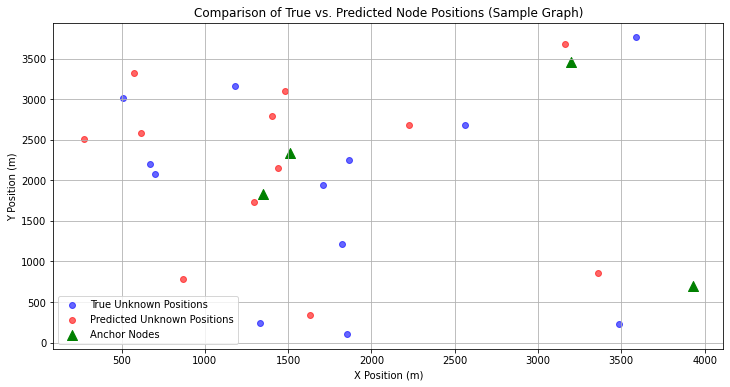

In [13]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, Parameter
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#######################################
# Parameters and Utility Functions
#######################################
num_instances = 600
num_anchors = 4
num_unknowns = 12
num_measurements = 10

# Origin from MATLAB code
mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (math.pi / 180) * earthRadius
metersPerDegreeLon = (math.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

#######################################
# Load Data
#######################################
data_list = []
for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"../matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    num_nodes = len(nodeLatitudes)
    node_x = np.zeros(num_nodes)
    node_y = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_x[i], node_y[i] = latlon_to_xy(nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon)

    # Construct edges
    edge_index_list = []
    edge_attr_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                # We will handle RSSI and delta_RSSI later. For now just store.
                edge_attr_list.append(signal_strength_matrix[i, j, :])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Identify anchors and unknowns
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:num_anchors] = True
    unknown_mask = ~anchor_mask

    # Initialize unknowns near average anchor position
    avg_anchor_x = node_x[anchor_mask].mean()
    avg_anchor_y = node_y[anchor_mask].mean()

    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < num_anchors else 0
        if is_anchor:
            node_features.append([node_x[i], node_y[i], is_anchor])
        else:
            node_features.append([avg_anchor_x + np.random.randn()*10,
                                  avg_anchor_y + np.random.randn()*10,
                                  is_anchor])

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    # Store original positions (not scaled) for distance calculation
    data.orig_positions = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data_list.append(data)

#######################################
# Scale Features and Targets
#######################################
all_features = torch.cat([d.x for d in data_list], dim=0).numpy()
feature_scaler = StandardScaler()
feature_scaler.fit(all_features)
for d in data_list:
    d.x = torch.tensor(feature_scaler.transform(d.x.numpy()), dtype=torch.float)

all_y = torch.cat([d.y for d in data_list], dim=0).numpy()
y_scaler = StandardScaler()
y_scaler.fit(all_y)
for d in data_list:
    d.y = torch.tensor(y_scaler.transform(d.y.numpy()), dtype=torch.float)

# Assume data_list contains 1000 instances
total_instances = len(data_list)
train_size = int(0.8 * total_instances)
test_size = total_instances - train_size

# Randomly split the data_list into training and testing sets
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# train_loader = DataLoader(data_list, batch_size=1, shuffle=True)
# test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

#######################################
# Physically Inspired Parameters
#######################################
# Learnable parameters for the RSSI model
Pt = Parameter(torch.tensor(0.0, requires_grad=True, device=device))
path_loss_exponent = Parameter(torch.tensor(3.0, requires_grad=True, device=device))
offset = Parameter(torch.tensor(-50.0, requires_grad=True, device=device))

#######################################
# Model Definition
#######################################
class MainEdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MainEdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 64),
            ReLU(),
            Linear(64, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class MainGNN(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, output_dim):
        super(MainGNN, self).__init__()
        self.edge_nn1 = MainEdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = MainEdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.fc(x)
        return x

node_in_dim = data_list[0].x.shape[1]
# We will add delta_RSSI as one additional feature to the existing edge attributes.
# Currently, edge_attr: shape = (num_edges, num_measurements)
# After adding delta_RSSI: shape = (num_edges, num_measurements + 1)
edge_in_dim = num_measurements + 1
hidden_dim = 64
output_dim = 2

main_gnn = MainGNN(node_in_dim=node_in_dim,
                   edge_in_dim=edge_in_dim,
                   hidden_dim=hidden_dim,
                   output_dim=output_dim).to(device)

params = list(main_gnn.parameters()) + [Pt, path_loss_exponent, offset]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-5)  # Lower LR for stability

#######################################
# Training
#######################################
num_epochs = 50
loss_history = []

def compute_distances(orig_positions, edge_index):
    # orig_positions: [num_nodes, 2]
    # edge_index: [2, num_edges]
    # return distances [num_edges, 1]
    src = edge_index[0]
    dst = edge_index[1]
    pos_src = orig_positions[src]
    pos_dst = orig_positions[dst]
    dist = torch.sqrt(torch.sum((pos_src - pos_dst)**2, dim=1))
    return dist

for epoch in range(num_epochs):
    main_gnn.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Compute distances in original space (not scaled)
        dist = compute_distances(data.orig_positions, data.edge_index)

        # Compute expected RSSI
        # RSSI_expected = Pt - 10 * path_loss_exponent * log10(dist) + offset
        # Avoid log10(0), add a small epsilon
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset

        # measured_RSSI: take mean over the 10 measurements for simplicity
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)

        # New edge_attr: original + delta_RSSI
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        # Use Smooth L1 Loss for robustness
        loss = F.smooth_l1_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(main_gnn.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_([Pt, path_loss_exponent, offset], 1.0)

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#######################################
# Evaluation
#######################################
main_gnn.eval()
errors_gcn = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        dist = compute_distances(data.orig_positions, data.edge_index)
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        predicted_scaled = out.cpu().numpy()
        predicted_positions = y_scaler.inverse_transform(predicted_scaled)
        true_positions = y_scaler.inverse_transform(data.y.cpu().numpy())

        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
                errors_gcn.append(error)

errors_gcn = np.array(errors_gcn)
plt.figure(figsize=(12, 6))
plt.hist(errors_gcn, bins=20, alpha=0.7, color='skyblue', label='GCN Errors')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

mean_error = errors_gcn.mean()
median_error = np.median(errors_gcn)
print(f"GCN Mean Error: {mean_error:.4f} m, Median Error: {median_error:.4f} m")

# Visualization of one sample
sample_data = data_list[0].to(device)
with torch.no_grad():
    dist = compute_distances(sample_data.orig_positions, sample_data.edge_index)
    epsilon = 1e-6
    RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
    measured_RSSI = sample_data.edge_attr.mean(dim=1)
    delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
    new_edge_attr = torch.cat([sample_data.edge_attr, delta_RSSI], dim=1)

    out = main_gnn(sample_data.x, sample_data.edge_index, new_edge_attr)
    predicted_scaled = out.cpu().numpy()
    predicted_positions = y_scaler.inverse_transform(predicted_scaled)
    true_positions = y_scaler.inverse_transform(sample_data.y.cpu().numpy())

predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

plt.figure(figsize=(12,6))
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0],
            true_positions[sample_data.unknown_mask.cpu(),1],
            c='blue', label='True Unknown Positions', alpha=0.6)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0],
            predicted_positions[sample_data.unknown_mask.cpu(),1],
            c='red', label='Predicted Unknown Positions', alpha=0.6)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0],
            true_positions[sample_data.anchor_mask.cpu(),1],
            c='green', marker='^', s=100, label='Anchor Nodes')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of True vs. Predicted Node Positions (Sample Graph)')
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


Loading MATLAB data: 100%|██████████| 700/700 [00:01<00:00, 635.43it/s] 
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 6.7799
Epoch 2, Loss: 3.6687
Epoch 3, Loss: 2.9636
Epoch 4, Loss: 2.3281
Epoch 5, Loss: 2.0864
Epoch 6, Loss: 1.6702
Epoch 7, Loss: 1.5172
Epoch 8, Loss: 1.2754
Epoch 9, Loss: 1.0043
Epoch 10, Loss: 0.8567
Epoch 11, Loss: 0.8640
Epoch 12, Loss: 0.6384
Epoch 13, Loss: 0.6126
Epoch 14, Loss: 0.5763
Epoch 15, Loss: 0.4621
Epoch 16, Loss: 0.4272
Epoch 17, Loss: 0.2782
Epoch 18, Loss: 0.2990
Epoch 19, Loss: 0.2354
Epoch 20, Loss: 0.2463
Epoch 21, Loss: 0.2287
Epoch 22, Loss: 0.1916
Epoch 23, Loss: 0.1697
Epoch 24, Loss: 0.1598
Epoch 25, Loss: 0.1464
Epoch 26, Loss: 0.1693
Epoch 27, Loss: 0.1518
Epoch 28, Loss: 0.1398
Epoch 29, Loss: 0.1255
Epoch 30, Loss: 0.1252
Epoch 31, Loss: 0.1189
Epoch 32, Loss: 0.1149
Epoch 33, Loss: 0.1166
Epoch 34, Loss: 0.1071
Epoch 35, Loss: 0.1125
Epoch 36, Loss: 0.1049
Epoch 37, Loss: 0.1019
Epoch 38, Loss: 0.0969
Epoch 39, Loss: 0.0846
Epoch 40, Loss: 0.0891
Epoch 41, Loss: 0.0864
Epoch 42, Loss: 0.0863
Epoch 43, Loss: 0.0772
Epoch 44, Loss: 0.07

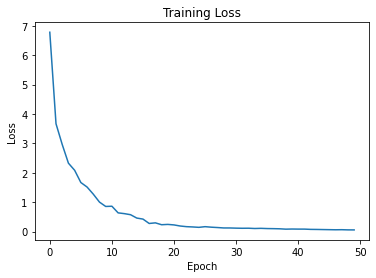

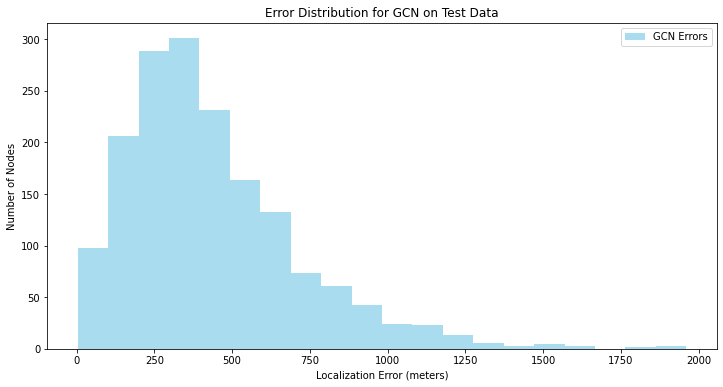

GCN Mean Error: 436.6016 m, Median Error: 375.6722 m


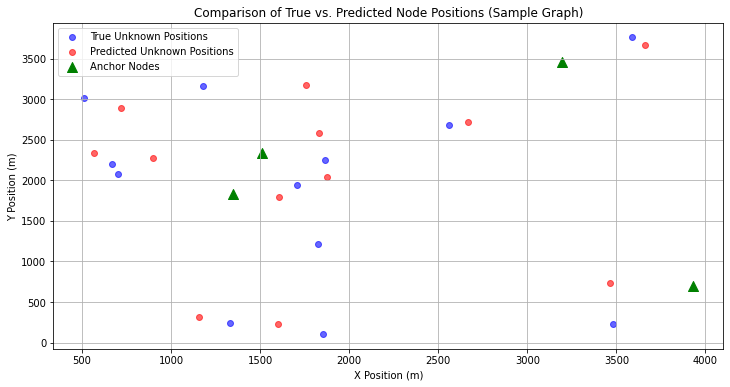

In [14]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, Parameter
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#######################################
# Parameters and Utility Functions
#######################################
num_instances = 700
num_anchors = 4
num_unknowns = 12
num_measurements = 10

# Origin from MATLAB code
mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (math.pi / 180) * earthRadius
metersPerDegreeLon = (math.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

#######################################
# Load Data
#######################################
data_list = []
for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"../matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    num_nodes = len(nodeLatitudes)
    node_x = np.zeros(num_nodes)
    node_y = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_x[i], node_y[i] = latlon_to_xy(nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon)

    # Construct edges
    edge_index_list = []
    edge_attr_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                # We will handle RSSI and delta_RSSI later. For now just store.
                edge_attr_list.append(signal_strength_matrix[i, j, :])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Identify anchors and unknowns
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:num_anchors] = True
    unknown_mask = ~anchor_mask

    # Initialize unknowns near average anchor position
    avg_anchor_x = node_x[anchor_mask].mean()
    avg_anchor_y = node_y[anchor_mask].mean()

    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < num_anchors else 0
        if is_anchor:
            node_features.append([node_x[i], node_y[i], is_anchor])
        else:
            node_features.append([avg_anchor_x + np.random.randn()*10,
                                  avg_anchor_y + np.random.randn()*10,
                                  is_anchor])

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    # Store original positions (not scaled) for distance calculation
    data.orig_positions = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data_list.append(data)

#######################################
# Scale Features and Targets
#######################################
all_features = torch.cat([d.x for d in data_list], dim=0).numpy()
feature_scaler = StandardScaler()
feature_scaler.fit(all_features)
for d in data_list:
    d.x = torch.tensor(feature_scaler.transform(d.x.numpy()), dtype=torch.float)

all_y = torch.cat([d.y for d in data_list], dim=0).numpy()
y_scaler = StandardScaler()
y_scaler.fit(all_y)
for d in data_list:
    d.y = torch.tensor(y_scaler.transform(d.y.numpy()), dtype=torch.float)

# Assume data_list contains 1000 instances
total_instances = len(data_list)
train_size = int(0.8 * total_instances)
test_size = total_instances - train_size

# Randomly split the data_list into training and testing sets
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# train_loader = DataLoader(data_list, batch_size=1, shuffle=True)
# test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

#######################################
# Physically Inspired Parameters
#######################################
# Learnable parameters for the RSSI model
Pt = Parameter(torch.tensor(0.0, requires_grad=True, device=device))
path_loss_exponent = Parameter(torch.tensor(3.0, requires_grad=True, device=device))
offset = Parameter(torch.tensor(-50.0, requires_grad=True, device=device))

#######################################
# Model Definition
#######################################
class MainEdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MainEdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 64),
            ReLU(),
            Linear(64, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class MainGNN(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, output_dim):
        super(MainGNN, self).__init__()
        self.edge_nn1 = MainEdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = MainEdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.fc(x)
        return x

node_in_dim = data_list[0].x.shape[1]
# We will add delta_RSSI as one additional feature to the existing edge attributes.
# Currently, edge_attr: shape = (num_edges, num_measurements)
# After adding delta_RSSI: shape = (num_edges, num_measurements + 1)
edge_in_dim = num_measurements + 1
hidden_dim = 64
output_dim = 2

main_gnn = MainGNN(node_in_dim=node_in_dim,
                   edge_in_dim=edge_in_dim,
                   hidden_dim=hidden_dim,
                   output_dim=output_dim).to(device)

params = list(main_gnn.parameters()) + [Pt, path_loss_exponent, offset]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-5)  # Lower LR for stability

#######################################
# Training
#######################################
num_epochs = 50
loss_history = []

def compute_distances(orig_positions, edge_index):
    # orig_positions: [num_nodes, 2]
    # edge_index: [2, num_edges]
    # return distances [num_edges, 1]
    src = edge_index[0]
    dst = edge_index[1]
    pos_src = orig_positions[src]
    pos_dst = orig_positions[dst]
    dist = torch.sqrt(torch.sum((pos_src - pos_dst)**2, dim=1))
    return dist

for epoch in range(num_epochs):
    main_gnn.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Compute distances in original space (not scaled)
        dist = compute_distances(data.orig_positions, data.edge_index)

        # Compute expected RSSI
        # RSSI_expected = Pt - 10 * path_loss_exponent * log10(dist) + offset
        # Avoid log10(0), add a small epsilon
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset

        # measured_RSSI: take mean over the 10 measurements for simplicity
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)

        # New edge_attr: original + delta_RSSI
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        # Use Smooth L1 Loss for robustness
        loss = F.smooth_l1_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(main_gnn.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_([Pt, path_loss_exponent, offset], 1.0)

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#######################################
# Evaluation
#######################################
main_gnn.eval()
errors_gcn = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        dist = compute_distances(data.orig_positions, data.edge_index)
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        predicted_scaled = out.cpu().numpy()
        predicted_positions = y_scaler.inverse_transform(predicted_scaled)
        true_positions = y_scaler.inverse_transform(data.y.cpu().numpy())

        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
                errors_gcn.append(error)

errors_gcn = np.array(errors_gcn)
plt.figure(figsize=(12, 6))
plt.hist(errors_gcn, bins=20, alpha=0.7, color='skyblue', label='GCN Errors')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

mean_error = errors_gcn.mean()
median_error = np.median(errors_gcn)
print(f"GCN Mean Error: {mean_error:.4f} m, Median Error: {median_error:.4f} m")

# Visualization of one sample
sample_data = data_list[0].to(device)
with torch.no_grad():
    dist = compute_distances(sample_data.orig_positions, sample_data.edge_index)
    epsilon = 1e-6
    RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
    measured_RSSI = sample_data.edge_attr.mean(dim=1)
    delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
    new_edge_attr = torch.cat([sample_data.edge_attr, delta_RSSI], dim=1)

    out = main_gnn(sample_data.x, sample_data.edge_index, new_edge_attr)
    predicted_scaled = out.cpu().numpy()
    predicted_positions = y_scaler.inverse_transform(predicted_scaled)
    true_positions = y_scaler.inverse_transform(sample_data.y.cpu().numpy())

predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

plt.figure(figsize=(12,6))
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0],
            true_positions[sample_data.unknown_mask.cpu(),1],
            c='blue', label='True Unknown Positions', alpha=0.6)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0],
            predicted_positions[sample_data.unknown_mask.cpu(),1],
            c='red', label='Predicted Unknown Positions', alpha=0.6)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0],
            true_positions[sample_data.anchor_mask.cpu(),1],
            c='green', marker='^', s=100, label='Anchor Nodes')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of True vs. Predicted Node Positions (Sample Graph)')
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


Loading MATLAB data: 100%|██████████| 800/800 [00:01<00:00, 639.37it/s] 
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 7.7245
Epoch 2, Loss: 4.2005
Epoch 3, Loss: 3.3261
Epoch 4, Loss: 2.6358
Epoch 5, Loss: 2.3297
Epoch 6, Loss: 2.2002
Epoch 7, Loss: 1.8927
Epoch 8, Loss: 1.9124
Epoch 9, Loss: 1.4893
Epoch 10, Loss: 1.3312
Epoch 11, Loss: 1.0854
Epoch 12, Loss: 0.8696
Epoch 13, Loss: 1.0213
Epoch 14, Loss: 0.8763
Epoch 15, Loss: 0.5929
Epoch 16, Loss: 0.5788
Epoch 17, Loss: 0.4131
Epoch 18, Loss: 0.4466
Epoch 19, Loss: 0.3833
Epoch 20, Loss: 0.2907
Epoch 21, Loss: 0.2612
Epoch 22, Loss: 0.2468
Epoch 23, Loss: 0.2197
Epoch 24, Loss: 0.2107
Epoch 25, Loss: 0.1860
Epoch 26, Loss: 0.1817
Epoch 27, Loss: 0.1557
Epoch 28, Loss: 0.1341
Epoch 29, Loss: 0.1396
Epoch 30, Loss: 0.1216
Epoch 31, Loss: 0.1051
Epoch 32, Loss: 0.1047
Epoch 33, Loss: 0.0981
Epoch 34, Loss: 0.0890
Epoch 35, Loss: 0.0948
Epoch 36, Loss: 0.0813
Epoch 37, Loss: 0.0755
Epoch 38, Loss: 0.0720
Epoch 39, Loss: 0.0677
Epoch 40, Loss: 0.0611
Epoch 41, Loss: 0.0577
Epoch 42, Loss: 0.0569
Epoch 43, Loss: 0.0530
Epoch 44, Loss: 0.04

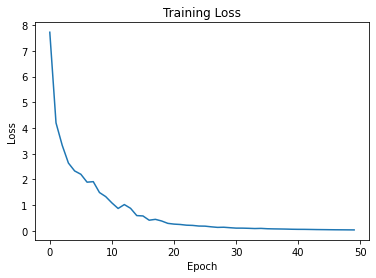

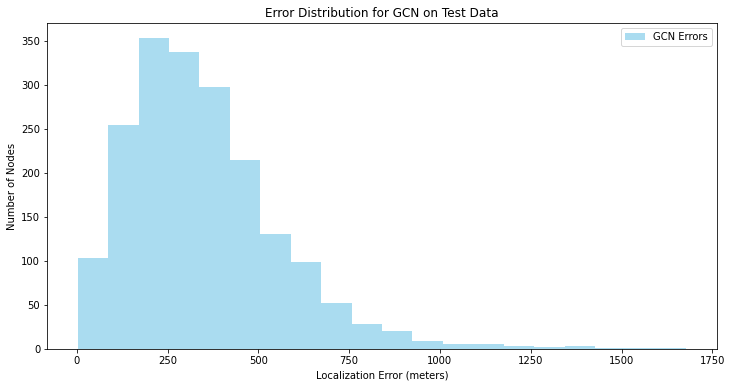

GCN Mean Error: 349.5924 m, Median Error: 315.2210 m


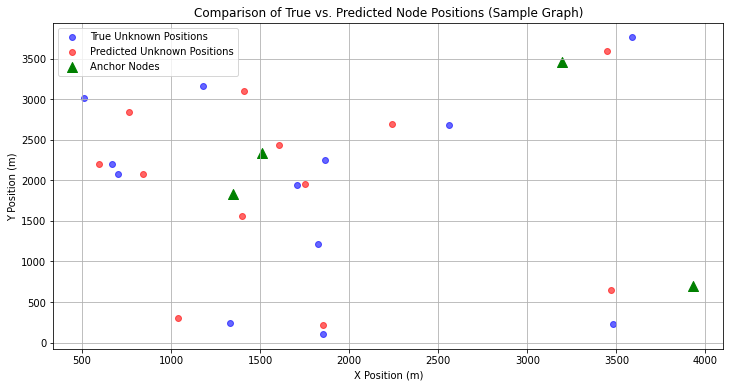

In [15]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, Parameter
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#######################################
# Parameters and Utility Functions
#######################################
num_instances = 800
num_anchors = 4
num_unknowns = 12
num_measurements = 10

# Origin from MATLAB code
mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (math.pi / 180) * earthRadius
metersPerDegreeLon = (math.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

#######################################
# Load Data
#######################################
data_list = []
for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"../matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    num_nodes = len(nodeLatitudes)
    node_x = np.zeros(num_nodes)
    node_y = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_x[i], node_y[i] = latlon_to_xy(nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon)

    # Construct edges
    edge_index_list = []
    edge_attr_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                # We will handle RSSI and delta_RSSI later. For now just store.
                edge_attr_list.append(signal_strength_matrix[i, j, :])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Identify anchors and unknowns
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:num_anchors] = True
    unknown_mask = ~anchor_mask

    # Initialize unknowns near average anchor position
    avg_anchor_x = node_x[anchor_mask].mean()
    avg_anchor_y = node_y[anchor_mask].mean()

    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < num_anchors else 0
        if is_anchor:
            node_features.append([node_x[i], node_y[i], is_anchor])
        else:
            node_features.append([avg_anchor_x + np.random.randn()*10,
                                  avg_anchor_y + np.random.randn()*10,
                                  is_anchor])

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    # Store original positions (not scaled) for distance calculation
    data.orig_positions = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data_list.append(data)

#######################################
# Scale Features and Targets
#######################################
all_features = torch.cat([d.x for d in data_list], dim=0).numpy()
feature_scaler = StandardScaler()
feature_scaler.fit(all_features)
for d in data_list:
    d.x = torch.tensor(feature_scaler.transform(d.x.numpy()), dtype=torch.float)

all_y = torch.cat([d.y for d in data_list], dim=0).numpy()
y_scaler = StandardScaler()
y_scaler.fit(all_y)
for d in data_list:
    d.y = torch.tensor(y_scaler.transform(d.y.numpy()), dtype=torch.float)

# Assume data_list contains 1000 instances
total_instances = len(data_list)
train_size = int(0.8 * total_instances)
test_size = total_instances - train_size

# Randomly split the data_list into training and testing sets
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# train_loader = DataLoader(data_list, batch_size=1, shuffle=True)
# test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

#######################################
# Physically Inspired Parameters
#######################################
# Learnable parameters for the RSSI model
Pt = Parameter(torch.tensor(0.0, requires_grad=True, device=device))
path_loss_exponent = Parameter(torch.tensor(3.0, requires_grad=True, device=device))
offset = Parameter(torch.tensor(-50.0, requires_grad=True, device=device))

#######################################
# Model Definition
#######################################
class MainEdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MainEdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 64),
            ReLU(),
            Linear(64, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class MainGNN(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, output_dim):
        super(MainGNN, self).__init__()
        self.edge_nn1 = MainEdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = MainEdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.fc(x)
        return x

node_in_dim = data_list[0].x.shape[1]
# We will add delta_RSSI as one additional feature to the existing edge attributes.
# Currently, edge_attr: shape = (num_edges, num_measurements)
# After adding delta_RSSI: shape = (num_edges, num_measurements + 1)
edge_in_dim = num_measurements + 1
hidden_dim = 64
output_dim = 2

main_gnn = MainGNN(node_in_dim=node_in_dim,
                   edge_in_dim=edge_in_dim,
                   hidden_dim=hidden_dim,
                   output_dim=output_dim).to(device)

params = list(main_gnn.parameters()) + [Pt, path_loss_exponent, offset]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-5)  # Lower LR for stability

#######################################
# Training
#######################################
num_epochs = 50
loss_history = []

def compute_distances(orig_positions, edge_index):
    # orig_positions: [num_nodes, 2]
    # edge_index: [2, num_edges]
    # return distances [num_edges, 1]
    src = edge_index[0]
    dst = edge_index[1]
    pos_src = orig_positions[src]
    pos_dst = orig_positions[dst]
    dist = torch.sqrt(torch.sum((pos_src - pos_dst)**2, dim=1))
    return dist

for epoch in range(num_epochs):
    main_gnn.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Compute distances in original space (not scaled)
        dist = compute_distances(data.orig_positions, data.edge_index)

        # Compute expected RSSI
        # RSSI_expected = Pt - 10 * path_loss_exponent * log10(dist) + offset
        # Avoid log10(0), add a small epsilon
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset

        # measured_RSSI: take mean over the 10 measurements for simplicity
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)

        # New edge_attr: original + delta_RSSI
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        # Use Smooth L1 Loss for robustness
        loss = F.smooth_l1_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(main_gnn.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_([Pt, path_loss_exponent, offset], 1.0)

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#######################################
# Evaluation
#######################################
main_gnn.eval()
errors_gcn = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        dist = compute_distances(data.orig_positions, data.edge_index)
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        predicted_scaled = out.cpu().numpy()
        predicted_positions = y_scaler.inverse_transform(predicted_scaled)
        true_positions = y_scaler.inverse_transform(data.y.cpu().numpy())

        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
                errors_gcn.append(error)

errors_gcn = np.array(errors_gcn)
plt.figure(figsize=(12, 6))
plt.hist(errors_gcn, bins=20, alpha=0.7, color='skyblue', label='GCN Errors')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

mean_error = errors_gcn.mean()
median_error = np.median(errors_gcn)
print(f"GCN Mean Error: {mean_error:.4f} m, Median Error: {median_error:.4f} m")

# Visualization of one sample
sample_data = data_list[0].to(device)
with torch.no_grad():
    dist = compute_distances(sample_data.orig_positions, sample_data.edge_index)
    epsilon = 1e-6
    RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
    measured_RSSI = sample_data.edge_attr.mean(dim=1)
    delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
    new_edge_attr = torch.cat([sample_data.edge_attr, delta_RSSI], dim=1)

    out = main_gnn(sample_data.x, sample_data.edge_index, new_edge_attr)
    predicted_scaled = out.cpu().numpy()
    predicted_positions = y_scaler.inverse_transform(predicted_scaled)
    true_positions = y_scaler.inverse_transform(sample_data.y.cpu().numpy())

predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

plt.figure(figsize=(12,6))
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0],
            true_positions[sample_data.unknown_mask.cpu(),1],
            c='blue', label='True Unknown Positions', alpha=0.6)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0],
            predicted_positions[sample_data.unknown_mask.cpu(),1],
            c='red', label='Predicted Unknown Positions', alpha=0.6)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0],
            true_positions[sample_data.anchor_mask.cpu(),1],
            c='green', marker='^', s=100, label='Anchor Nodes')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of True vs. Predicted Node Positions (Sample Graph)')
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


Loading MATLAB data: 100%|██████████| 900/900 [00:01<00:00, 651.86it/s]
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 6.6940
Epoch 2, Loss: 2.7478
Epoch 3, Loss: 1.9109
Epoch 4, Loss: 2.0251
Epoch 5, Loss: 1.5269
Epoch 6, Loss: 1.2496
Epoch 7, Loss: 1.1984
Epoch 8, Loss: 0.9368
Epoch 9, Loss: 0.8824
Epoch 10, Loss: 0.7068
Epoch 11, Loss: 0.6450
Epoch 12, Loss: 0.6254
Epoch 13, Loss: 0.4883
Epoch 14, Loss: 0.4157
Epoch 15, Loss: 0.3415
Epoch 16, Loss: 0.2978
Epoch 17, Loss: 0.2383
Epoch 18, Loss: 0.2480
Epoch 19, Loss: 0.2184
Epoch 20, Loss: 0.1892
Epoch 21, Loss: 0.1821
Epoch 22, Loss: 0.1697
Epoch 23, Loss: 0.1600
Epoch 24, Loss: 0.1433
Epoch 25, Loss: 0.1282
Epoch 26, Loss: 0.1259
Epoch 27, Loss: 0.1239
Epoch 28, Loss: 0.1092
Epoch 29, Loss: 0.1015
Epoch 30, Loss: 0.0925
Epoch 31, Loss: 0.0857
Epoch 32, Loss: 0.0826
Epoch 33, Loss: 0.0787
Epoch 34, Loss: 0.0724
Epoch 35, Loss: 0.0654
Epoch 36, Loss: 0.0646
Epoch 37, Loss: 0.0631
Epoch 38, Loss: 0.0594
Epoch 39, Loss: 0.0562
Epoch 40, Loss: 0.0514
Epoch 41, Loss: 0.0497
Epoch 42, Loss: 0.0465
Epoch 43, Loss: 0.0444
Epoch 44, Loss: 0.04

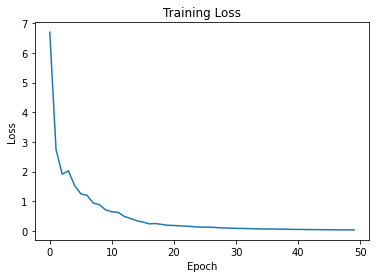

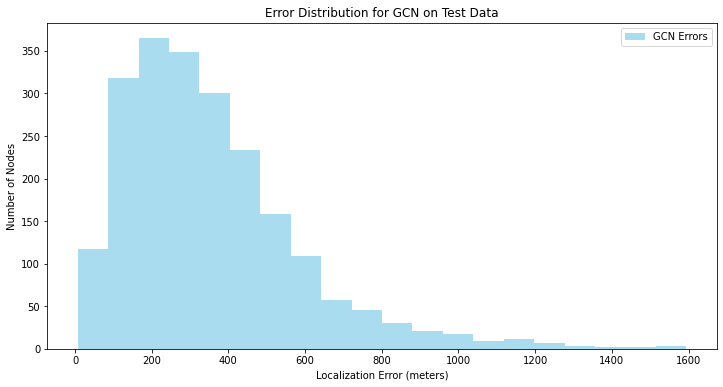

GCN Mean Error: 353.4228 m, Median Error: 307.8706 m


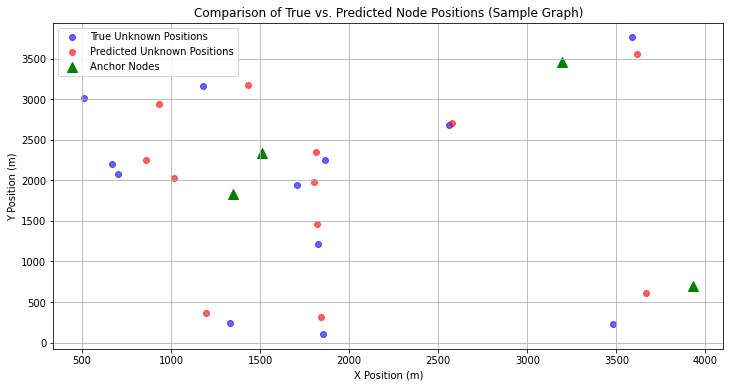

In [16]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, Parameter
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#######################################
# Parameters and Utility Functions
#######################################
num_instances = 900
num_anchors = 4
num_unknowns = 12
num_measurements = 10

# Origin from MATLAB code
mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (math.pi / 180) * earthRadius
metersPerDegreeLon = (math.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

#######################################
# Load Data
#######################################
data_list = []
for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"../matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    num_nodes = len(nodeLatitudes)
    node_x = np.zeros(num_nodes)
    node_y = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_x[i], node_y[i] = latlon_to_xy(nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon)

    # Construct edges
    edge_index_list = []
    edge_attr_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                # We will handle RSSI and delta_RSSI later. For now just store.
                edge_attr_list.append(signal_strength_matrix[i, j, :])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Identify anchors and unknowns
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:num_anchors] = True
    unknown_mask = ~anchor_mask

    # Initialize unknowns near average anchor position
    avg_anchor_x = node_x[anchor_mask].mean()
    avg_anchor_y = node_y[anchor_mask].mean()

    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < num_anchors else 0
        if is_anchor:
            node_features.append([node_x[i], node_y[i], is_anchor])
        else:
            node_features.append([avg_anchor_x + np.random.randn()*10,
                                  avg_anchor_y + np.random.randn()*10,
                                  is_anchor])

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    # Store original positions (not scaled) for distance calculation
    data.orig_positions = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data_list.append(data)

#######################################
# Scale Features and Targets
#######################################
all_features = torch.cat([d.x for d in data_list], dim=0).numpy()
feature_scaler = StandardScaler()
feature_scaler.fit(all_features)
for d in data_list:
    d.x = torch.tensor(feature_scaler.transform(d.x.numpy()), dtype=torch.float)

all_y = torch.cat([d.y for d in data_list], dim=0).numpy()
y_scaler = StandardScaler()
y_scaler.fit(all_y)
for d in data_list:
    d.y = torch.tensor(y_scaler.transform(d.y.numpy()), dtype=torch.float)

# Assume data_list contains 1000 instances
total_instances = len(data_list)
train_size = int(0.8 * total_instances)
test_size = total_instances - train_size

# Randomly split the data_list into training and testing sets
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# train_loader = DataLoader(data_list, batch_size=1, shuffle=True)
# test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

#######################################
# Physically Inspired Parameters
#######################################
# Learnable parameters for the RSSI model
Pt = Parameter(torch.tensor(0.0, requires_grad=True, device=device))
path_loss_exponent = Parameter(torch.tensor(3.0, requires_grad=True, device=device))
offset = Parameter(torch.tensor(-50.0, requires_grad=True, device=device))

#######################################
# Model Definition
#######################################
class MainEdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MainEdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 64),
            ReLU(),
            Linear(64, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class MainGNN(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, output_dim):
        super(MainGNN, self).__init__()
        self.edge_nn1 = MainEdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = MainEdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.fc(x)
        return x

node_in_dim = data_list[0].x.shape[1]
# We will add delta_RSSI as one additional feature to the existing edge attributes.
# Currently, edge_attr: shape = (num_edges, num_measurements)
# After adding delta_RSSI: shape = (num_edges, num_measurements + 1)
edge_in_dim = num_measurements + 1
hidden_dim = 64
output_dim = 2

main_gnn = MainGNN(node_in_dim=node_in_dim,
                   edge_in_dim=edge_in_dim,
                   hidden_dim=hidden_dim,
                   output_dim=output_dim).to(device)

params = list(main_gnn.parameters()) + [Pt, path_loss_exponent, offset]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-5)  # Lower LR for stability

#######################################
# Training
#######################################
num_epochs = 50
loss_history = []

def compute_distances(orig_positions, edge_index):
    # orig_positions: [num_nodes, 2]
    # edge_index: [2, num_edges]
    # return distances [num_edges, 1]
    src = edge_index[0]
    dst = edge_index[1]
    pos_src = orig_positions[src]
    pos_dst = orig_positions[dst]
    dist = torch.sqrt(torch.sum((pos_src - pos_dst)**2, dim=1))
    return dist

for epoch in range(num_epochs):
    main_gnn.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Compute distances in original space (not scaled)
        dist = compute_distances(data.orig_positions, data.edge_index)

        # Compute expected RSSI
        # RSSI_expected = Pt - 10 * path_loss_exponent * log10(dist) + offset
        # Avoid log10(0), add a small epsilon
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset

        # measured_RSSI: take mean over the 10 measurements for simplicity
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)

        # New edge_attr: original + delta_RSSI
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        # Use Smooth L1 Loss for robustness
        loss = F.smooth_l1_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(main_gnn.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_([Pt, path_loss_exponent, offset], 1.0)

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#######################################
# Evaluation
#######################################
main_gnn.eval()
errors_gcn = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        dist = compute_distances(data.orig_positions, data.edge_index)
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        predicted_scaled = out.cpu().numpy()
        predicted_positions = y_scaler.inverse_transform(predicted_scaled)
        true_positions = y_scaler.inverse_transform(data.y.cpu().numpy())

        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
                errors_gcn.append(error)

errors_gcn = np.array(errors_gcn)
plt.figure(figsize=(12, 6))
plt.hist(errors_gcn, bins=20, alpha=0.7, color='skyblue', label='GCN Errors')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

mean_error = errors_gcn.mean()
median_error = np.median(errors_gcn)
print(f"GCN Mean Error: {mean_error:.4f} m, Median Error: {median_error:.4f} m")

# Visualization of one sample
sample_data = data_list[0].to(device)
with torch.no_grad():
    dist = compute_distances(sample_data.orig_positions, sample_data.edge_index)
    epsilon = 1e-6
    RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
    measured_RSSI = sample_data.edge_attr.mean(dim=1)
    delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
    new_edge_attr = torch.cat([sample_data.edge_attr, delta_RSSI], dim=1)

    out = main_gnn(sample_data.x, sample_data.edge_index, new_edge_attr)
    predicted_scaled = out.cpu().numpy()
    predicted_positions = y_scaler.inverse_transform(predicted_scaled)
    true_positions = y_scaler.inverse_transform(sample_data.y.cpu().numpy())

predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

plt.figure(figsize=(12,6))
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0],
            true_positions[sample_data.unknown_mask.cpu(),1],
            c='blue', label='True Unknown Positions', alpha=0.6)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0],
            predicted_positions[sample_data.unknown_mask.cpu(),1],
            c='red', label='Predicted Unknown Positions', alpha=0.6)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0],
            true_positions[sample_data.anchor_mask.cpu(),1],
            c='green', marker='^', s=100, label='Anchor Nodes')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of True vs. Predicted Node Positions (Sample Graph)')
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


Loading MATLAB data: 100%|██████████| 1000/1000 [00:01<00:00, 685.52it/s]
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 8.2149
Epoch 2, Loss: 4.0355
Epoch 3, Loss: 2.9544
Epoch 4, Loss: 2.6852
Epoch 5, Loss: 2.1798
Epoch 6, Loss: 1.7536
Epoch 7, Loss: 1.3627
Epoch 8, Loss: 1.0154
Epoch 9, Loss: 0.9785
Epoch 10, Loss: 0.8171
Epoch 11, Loss: 0.6172
Epoch 12, Loss: 0.4793
Epoch 13, Loss: 0.4258
Epoch 14, Loss: 0.3693
Epoch 15, Loss: 0.3264
Epoch 16, Loss: 0.2814
Epoch 17, Loss: 0.2439
Epoch 18, Loss: 0.2346
Epoch 19, Loss: 0.2122
Epoch 20, Loss: 0.2022
Epoch 21, Loss: 0.1826
Epoch 22, Loss: 0.1835
Epoch 23, Loss: 0.1802
Epoch 24, Loss: 0.1529
Epoch 25, Loss: 0.1338
Epoch 26, Loss: 0.1413
Epoch 27, Loss: 0.1431
Epoch 28, Loss: 0.1303
Epoch 29, Loss: 0.1186
Epoch 30, Loss: 0.1178
Epoch 31, Loss: 0.1151
Epoch 32, Loss: 0.1077
Epoch 33, Loss: 0.0995
Epoch 34, Loss: 0.0966
Epoch 35, Loss: 0.0965
Epoch 36, Loss: 0.0906
Epoch 37, Loss: 0.0853
Epoch 38, Loss: 0.0834
Epoch 39, Loss: 0.0873
Epoch 40, Loss: 0.0738
Epoch 41, Loss: 0.0769
Epoch 42, Loss: 0.0717
Epoch 43, Loss: 0.0718
Epoch 44, Loss: 0.06

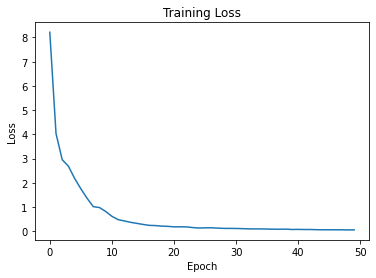

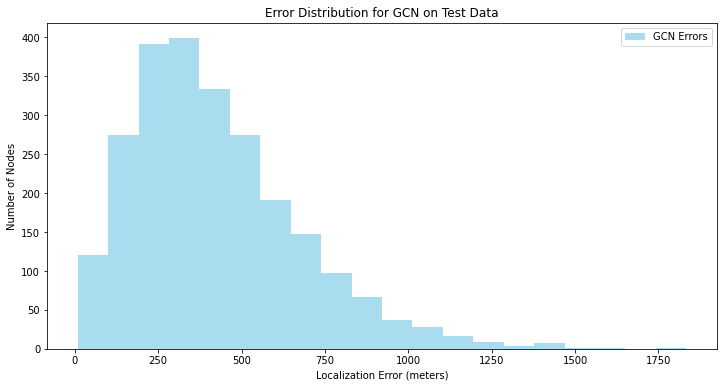

GCN Mean Error: 423.8367 m, Median Error: 376.0045 m


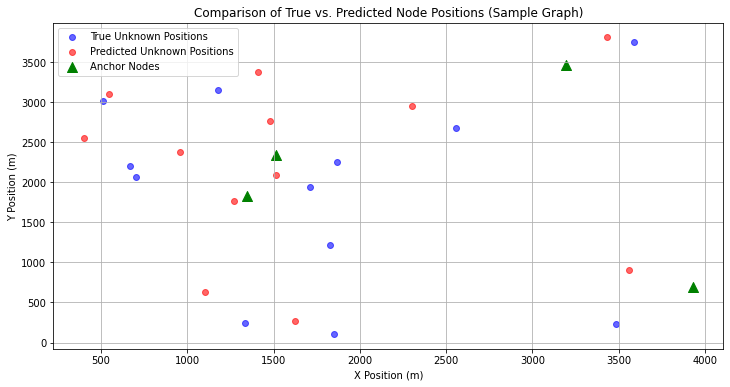

In [17]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, Parameter
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#######################################
# Parameters and Utility Functions
#######################################
num_instances = 1000
num_anchors = 4
num_unknowns = 12
num_measurements = 10

# Origin from MATLAB code
mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (math.pi / 180) * earthRadius
metersPerDegreeLon = (math.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

#######################################
# Load Data
#######################################
data_list = []
for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"../matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    num_nodes = len(nodeLatitudes)
    node_x = np.zeros(num_nodes)
    node_y = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_x[i], node_y[i] = latlon_to_xy(nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon)

    # Construct edges
    edge_index_list = []
    edge_attr_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                # We will handle RSSI and delta_RSSI later. For now just store.
                edge_attr_list.append(signal_strength_matrix[i, j, :])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Identify anchors and unknowns
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:num_anchors] = True
    unknown_mask = ~anchor_mask

    # Initialize unknowns near average anchor position
    avg_anchor_x = node_x[anchor_mask].mean()
    avg_anchor_y = node_y[anchor_mask].mean()

    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < num_anchors else 0
        if is_anchor:
            node_features.append([node_x[i], node_y[i], is_anchor])
        else:
            node_features.append([avg_anchor_x + np.random.randn()*10,
                                  avg_anchor_y + np.random.randn()*10,
                                  is_anchor])

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    # Store original positions (not scaled) for distance calculation
    data.orig_positions = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data_list.append(data)

#######################################
# Scale Features and Targets
#######################################
all_features = torch.cat([d.x for d in data_list], dim=0).numpy()
feature_scaler = StandardScaler()
feature_scaler.fit(all_features)
for d in data_list:
    d.x = torch.tensor(feature_scaler.transform(d.x.numpy()), dtype=torch.float)

all_y = torch.cat([d.y for d in data_list], dim=0).numpy()
y_scaler = StandardScaler()
y_scaler.fit(all_y)
for d in data_list:
    d.y = torch.tensor(y_scaler.transform(d.y.numpy()), dtype=torch.float)

# Assume data_list contains 1000 instances
total_instances = len(data_list)
train_size = int(0.8 * total_instances)
test_size = total_instances - train_size

# Randomly split the data_list into training and testing sets
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# train_loader = DataLoader(data_list, batch_size=1, shuffle=True)
# test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

#######################################
# Physically Inspired Parameters
#######################################
# Learnable parameters for the RSSI model
Pt = Parameter(torch.tensor(0.0, requires_grad=True, device=device))
path_loss_exponent = Parameter(torch.tensor(3.0, requires_grad=True, device=device))
offset = Parameter(torch.tensor(-50.0, requires_grad=True, device=device))

#######################################
# Model Definition
#######################################
class MainEdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MainEdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 64),
            ReLU(),
            Linear(64, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class MainGNN(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, output_dim):
        super(MainGNN, self).__init__()
        self.edge_nn1 = MainEdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = MainEdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.fc(x)
        return x

node_in_dim = data_list[0].x.shape[1]
# We will add delta_RSSI as one additional feature to the existing edge attributes.
# Currently, edge_attr: shape = (num_edges, num_measurements)
# After adding delta_RSSI: shape = (num_edges, num_measurements + 1)
edge_in_dim = num_measurements + 1
hidden_dim = 64
output_dim = 2

main_gnn = MainGNN(node_in_dim=node_in_dim,
                   edge_in_dim=edge_in_dim,
                   hidden_dim=hidden_dim,
                   output_dim=output_dim).to(device)

params = list(main_gnn.parameters()) + [Pt, path_loss_exponent, offset]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-5)  # Lower LR for stability

#######################################
# Training
#######################################
num_epochs = 50
loss_history = []

def compute_distances(orig_positions, edge_index):
    # orig_positions: [num_nodes, 2]
    # edge_index: [2, num_edges]
    # return distances [num_edges, 1]
    src = edge_index[0]
    dst = edge_index[1]
    pos_src = orig_positions[src]
    pos_dst = orig_positions[dst]
    dist = torch.sqrt(torch.sum((pos_src - pos_dst)**2, dim=1))
    return dist

for epoch in range(num_epochs):
    main_gnn.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Compute distances in original space (not scaled)
        dist = compute_distances(data.orig_positions, data.edge_index)

        # Compute expected RSSI
        # RSSI_expected = Pt - 10 * path_loss_exponent * log10(dist) + offset
        # Avoid log10(0), add a small epsilon
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset

        # measured_RSSI: take mean over the 10 measurements for simplicity
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)

        # New edge_attr: original + delta_RSSI
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        # Use Smooth L1 Loss for robustness
        loss = F.smooth_l1_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(main_gnn.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_([Pt, path_loss_exponent, offset], 1.0)

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#######################################
# Evaluation
#######################################
main_gnn.eval()
errors_gcn = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        dist = compute_distances(data.orig_positions, data.edge_index)
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        predicted_scaled = out.cpu().numpy()
        predicted_positions = y_scaler.inverse_transform(predicted_scaled)
        true_positions = y_scaler.inverse_transform(data.y.cpu().numpy())

        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
                errors_gcn.append(error)

errors_gcn = np.array(errors_gcn)
plt.figure(figsize=(12, 6))
plt.hist(errors_gcn, bins=20, alpha=0.7, color='skyblue', label='GCN Errors')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

mean_error = errors_gcn.mean()
median_error = np.median(errors_gcn)
print(f"GCN Mean Error: {mean_error:.4f} m, Median Error: {median_error:.4f} m")

# Visualization of one sample
sample_data = data_list[0].to(device)
with torch.no_grad():
    dist = compute_distances(sample_data.orig_positions, sample_data.edge_index)
    epsilon = 1e-6
    RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
    measured_RSSI = sample_data.edge_attr.mean(dim=1)
    delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
    new_edge_attr = torch.cat([sample_data.edge_attr, delta_RSSI], dim=1)

    out = main_gnn(sample_data.x, sample_data.edge_index, new_edge_attr)
    predicted_scaled = out.cpu().numpy()
    predicted_positions = y_scaler.inverse_transform(predicted_scaled)
    true_positions = y_scaler.inverse_transform(sample_data.y.cpu().numpy())

predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

plt.figure(figsize=(12,6))
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0],
            true_positions[sample_data.unknown_mask.cpu(),1],
            c='blue', label='True Unknown Positions', alpha=0.6)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0],
            predicted_positions[sample_data.unknown_mask.cpu(),1],
            c='red', label='Predicted Unknown Positions', alpha=0.6)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0],
            true_positions[sample_data.anchor_mask.cpu(),1],
            c='green', marker='^', s=100, label='Anchor Nodes')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of True vs. Predicted Node Positions (Sample Graph)')
plt.legend()
plt.grid(True)
plt.show()
